# EN.705.625 — Introduction to Agentic AI  
## Lecture Notes Module 12 - Agentic RAG 

**Authors:** Vy Vu, Dr. Erhan Guven, Amir K. Saeed, Dr. Benjamin Rodriguez<br>
**Created Date:** 11/28/2025 <br>
**Modified Date:** --

<h1 style="font-size:25px; font-weight:bold">Table of Contents</h1>

1. RAG Foundations

2. Foundations and Theory

    2.1 The Evolution from RAG to Agentic RAG
    
    2.2 Core Components of Agentic RAG

    2.3 Theoretical Framework

3. Implementation and Technical Deep Dive

    3.1 Implementation Patterns

    3.2 Technical Implementation Details

4. Advanced Topics and Applications
5. References

<h1 id='module-overview-and-learning-objectives' style="font-size:23px; font-weight:bold;">Module Overview and Learning Objectives</h1>

- Differentiate between traditional RAG and Agentic RAG systems
- Design multi-step retrieval strategies for complex queries
- Implement an agentic RAG system with reasoning capabilities
- Evaluate the performance of agentic systems using appropriate metrics
- Apply agentic RAG patterns to real-world problems
- Analyze trade-offs in different agentic architectures

# 1. Retrieval-Augmented Generation (RAG) Foundations

---

## What Is RAG?

**Retrieval-Augmented Generation (RAG)** is a hybrid AI architecture that unites two paradigms:

- **Retrieval systems** — to find relevant external information at query time.  
- **Generative models (LLMs)** — to compose a coherent natural-language answer using that information.

Instead of relying only on static training data, a RAG system can **consult an external knowledge base** dynamically.  
This makes its outputs more **accurate, current, and explainable**.

### Motivation
Traditional LLMs suffer from:
- **Knowledge staleness** — can’t access information after training cut-off.
- **Hallucination** — produce plausible but false statements.
- **Poor domain recall** — weak on specialized or proprietary material.

RAG mitigates all of these by grounding the LLM in retrieved, factual documents.

### Conceptual Flow

User Query
    → (Embedding)
Retriever → Top-k Documents
    →
Augment prompt with retrieved context
    →
LLM Generator → Grounded Answer (+ citations)


---

## From Keyword Search to Semantic Retrieval

### A. Keyword (Sparse) Retrieval
- Early systems used **inverted indices** mapping terms → documents.
- Ranking relied on **TF-IDF** or **BM25**.
- Great for *exact term matches* but brittle to paraphrasing or synonyms.

### B. Neural (Dense) Retrieval
- Modern systems use **embeddings** — numerical vectors capturing meaning.
- Two semantically similar texts will have **close vector representations**.
- Enables **semantic similarity search** using cosine or dot-product distance.

### C. Why the Transition?
| Limitation (Sparse) | Remedy (Dense) |
|----------------------|----------------|
| No understanding of meaning | Embeddings encode semantics |
| Language mismatch | Cross-lingual dense spaces |
| Poor generalization | Continuous vector proximity |

Most production systems today use **hybrid retrieval** — combining BM25 (lexical) and dense embeddings (semantic).

---

## Indexing Fundamentals

**Indexing** prepares your documents for fast and accurate retrieval.

### Steps
1. **Chunking** — split long docs into manageable, semantically coherent units (e.g., 512–1024 tokens).  
2. **Embedding** — convert each chunk into a dense vector using a model like `text-embedding-3-large` or `all-MiniLM`.  
3. **Metadata tagging** — add title, author, date, source URL, etc.  
4. **Store in index** — save embeddings + metadata in a database optimized for similarity search.

Result: an *index* — a semantic map of your knowledge base.

### Key Design Considerations
- **Chunk size** too small → context fragmentation. Too large → diluted similarity.  
- **Overlap** between chunks maintains continuity across boundaries.  
- **Metadata** allows post-retrieval filtering (e.g., by source or date).

---

## ANN Indexing Families — FAISS & Beyond

Dense retrieval requires searching billions of vectors efficiently.  
That’s where **Approximate Nearest Neighbor (ANN)** algorithms come in.

### FAISS (Facebook AI Similarity Search)
A C++/Python library for building and querying vector indices.

#### Common FAISS Index Types
| Type | Description | Use Case |
|------|--------------|----------|
| **Flat (IndexFlatL2/IP)** | Exact search (brute force) | Small (<100k vectors), highest accuracy |
| **IVF (Inverted File)** | Coarse quantization into clusters (nlist/nprobe) | Millions of vectors |
| **PQ / OPQ** | Product Quantization (compression) | Memory-efficient billion-scale search |
| **HNSW** | Graph-based search | Fast, high recall, widely adopted |

### Alternative ANN Frameworks
- **Annoy** — tree-based, lightweight, great for static read-heavy indices.  
- **NMSLIB** — multiple algorithms, including HNSW.  
- **ScaNN** — Google’s quantization + reordering for high-throughput search.  

### Trade-offs
- **Speed vs Accuracy** — more approximation → faster but lower recall.  
- **Memory vs Recall** — quantization reduces memory footprint at small cost to accuracy.  
- **Build time vs Query time** — graph methods take longer to build but query quickly.

---

## Evolution to Vector Databases

While FAISS and similar libraries handle indexing, modern applications need **production-grade vector databases** to manage scale, reliability, and metadata.

### Why We Needed Vector Databases
- Persistence & replication  
- Sharding and distributed search  
- Metadata filters & hybrid queries  
- APIs for insert/update/delete  
- Access control and multi-tenancy

### Popular Vector Databases

| Database | Core Index | Highlights |
|-----------|-------------|------------|
| **Pinecone** | HNSW / IVF-PQ | Fully managed, serverless-like scalability |
| **Weaviate** | HNSW | GraphQL API, hybrid dense+sparse retrieval |
| **Milvus / Zilliz** | IVF / HNSW / PQ | CNCF project, billion-scale performance |
| **Qdrant** | HNSW | Rust backend, payload filters, open source |
| **Chroma** | HNSW (local) | Lightweight, ideal for prototyping |
| **Elasticsearch / OpenSearch** | kNN plugin | Combine BM25 + dense in one engine |
| **Postgres + pgvector** | Flat / HNSW | SQL integration, transactional guarantees |
| **Redis (vector fields)** | HNSW | In-memory, sub-millisecond latency |
| **Vespa** | HNSW / Hybrid | Query pipelines, large-scale production search |

Each adds management features on top of raw ANN indexing.

---

## Search Strategies

Retrieval quality depends heavily on how search is executed.

### a. First-Stage Recall
- **Dense-only search** — embed query, run ANN search, return top-k.  
- **Sparse-only search** — BM25/inverted index.  
- **Hybrid search** — combine results using *Reciprocal Rank Fusion (RRF)* or learned weighting.

### b. Query Reformulation
- **Expansion** — add synonyms or paraphrases.  
- **Decomposition** — split multi-part questions into smaller queries.  
- **HyDE (Hypothetical Document Expansion)** — generate a pseudo-answer, embed it, and retrieve using that representation.

### c. Reranking
- **Lexical rerank** — BM25 scoring within top-k.  
- **Bi-encoder rerank** — lighter dense model for secondary scoring.  
- **Cross-encoder rerank** — transformer that jointly encodes `[query, passage]`; highest accuracy, slower latency.

### d. Diversity & Freshness
- **MMR (Maximal Marginal Relevance)** — promotes topic diversity among top results.  
- **Recency bias** — time-decay weighting for freshness.  
- **Authority weighting** — boost trusted or official sources.

---

## How RAG Augments Generation

Once retrieval is complete, the retrieved chunks are *injected into the model’s prompt* to **ground** the generation process.

### a. Prompt Composition Patterns
| Pattern | Description | Pros / Cons |
|----------|--------------|--------------|
| **Stuff** | Concatenate top-k chunks into one long prompt. | Simple but can exceed context window. |
| **Refine** | Iteratively update an answer using each chunk. | Handles long contexts gracefully. |
| **Map-Reduce** | Summarize chunks individually, then combine. | Scalable; maintains coverage. |
| **Citation-Constrained** | Include reference tags and require citations. | Improves faithfulness and traceability. |

### b. Guardrails for Faithfulness
- Explicit instruction: *“Answer only using the provided context.”*  
- **Cite-then-answer** pattern: choose supporting passages before generating.  
- **Constrained decoding**: enforce templates or JSON schema to keep citations structured.  
- **Judge loop**: an evaluator model scores the answer (0–10); low scores trigger re-retrieval or re-generation.

### c. Caching & Memory
- **Embedding cache** — store previous embeddings to avoid recomputation.  
- **Result cache** — remember query → doc IDs for popular queries.  
- **Short-term conversation memory** — retain last N question-answer pairs to maintain context in multi-turn dialogue.

### Benefits
- Reduces hallucinations.  
- Provides traceable, verifiable answers.  
- Keeps knowledge up-to-date without retraining.  
- Enhances explainability via citations and metadata.


<h1 id='foundations-and-theory' style="font-size:23px; font-weight:bold;">2. Foundations and Theory</h1>

<h2 id="the-evolution-from-rag-to-agentic-rag" style="font-size:20px; font-weight:bold;">2.1 Introduction: The Evolution from RAG to Agentic RAG</h2>

**The Limitations of Traditional RAG**

Traditional Retrieval-Augmented Generation (RAG) systems follow a simple pipeline:

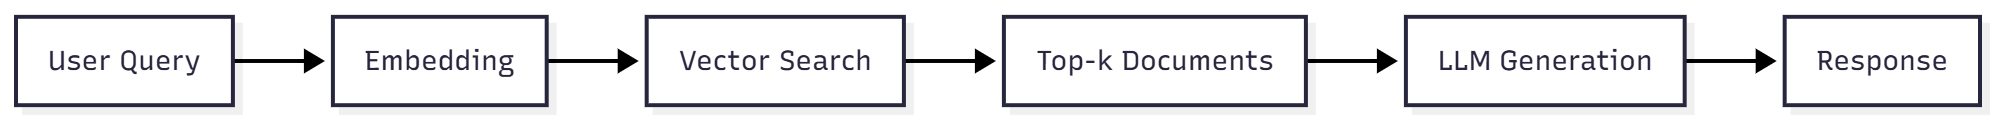


Basically, when a user submits a query, it first gets converted into a numerical representation (embedding) using an embedding model like BERT or Sentence-Transformers. This embedding is then used to perform a similarity search against a vector database containing pre-embedded documents. The system retrieves the top-k most similar documents based on cosine similarity or another distance metric. These retrieved documents are concatenated and passed as context to a Large Language Model (LLM) along with the original query. The LLM then generates a response based on this fixed context. This entire process happens in a single pass without any opportunity for refinement, reasoning about the quality of retrieved documents, or iterative improvement. The system simply retrieves once and generates once, regardless of whether the retrieved documents actually contain the information needed to answer the query comprehensively.

From there, we can identify several key limitations of traditional RAG:

1. Static Retrieval Strategy

- Single-shot retrieval without iteration.
- No ability to refine search based on initial results.
- Fixed number of documents retrieved regardless of query complexity.

2. Lack of Reasoning

- No understanding of why certain documents are relevant
- Cannot identify information gaps
- No ability to synthesize information from multiple sources strategically


3. No Query Understanding

- Treats all queries uniformly
- Cannot decompose complex multi-part questions
- No recognition of implicit information needs

4. Absence of Self-Correction

- Cannot detect when retrieved information is insufficient
- No mechanism to identify contradictions
- Cannot request clarification or additional context

These constraints highlight the need for a more intelligent and dynamic approach, which doesn't just retrieve and generate once, but can reason, reflect, and adapt. This is where Agentic RAG comes in. It extends traditional RAG by embedding agent-like capabilities that allow the model to analyze the quality of retrieved content, reformulate queries, and iteratively improve the final answer.

```text
-- Traditional RAG (Simplified)
def traditional_rag(query, retriever, llm):
    docs = retriever.search(query, k=5)
    context = "\n".join([doc.text for doc in docs])
    response = llm.generate(f"Context: {context}\nQuery: {query}")
    return response

-- Agentic RAG (Conceptual)
def agentic_rag(query, agent):
    plan = agent.create_plan(query)
    context = []
    
    for step in plan:
        if step.action == "retrieve":
            docs = agent.retrieve_with_reasoning(step.sub_query)
            context.extend(agent.evaluate_relevance(docs))
        elif step.action == "reason":
            inference = agent.reason_about_information(context)
            if inference.reveals_gap:
                plan.add_step(create_retrieval_step(inference.gap))
        elif step.action == "use_tool":
            result = agent.use_tool(step.tool, step.params)
            context.append(result)
    
    response = agent.synthesize_answer(query, context)
    if not agent.validate_answer(response):
        return agent.refine_iteratively(response, context)
    return response
```

**Example**

Consider a pharmaceutical company researcher asking:

*"What are the contraindications for our new diabetes drug XYZ-123 when used with common hypertension medications, and how do they compare to our competitor's drug ABC-789?"*

1. <u>Traditional RAG Approach:</u>

- Searches for "XYZ-123 contraindications hypertension ABC-789"
- Returns top 5 documents
- Generates response from whatever was retrieved


2. <u>Agentic RAG Approach:</u>

- Decomposes the query:

    >- What are the contraindications for XYZ-123?
    >- Which hypertension medications are commonly used?
    >- What are the specific interactions between XYZ-123 and each hypertension medication?
    >- What are the contraindications for ABC-789?
    >- How do the contraindication profiles compare?

- Plans retrieval strategy:

    >- Search internal drug database for XYZ-123 specifications
    >- Query FDA database for approved hypertension medications
    >- Search medical literature for drug interactions
    >- Retrieve competitor information from public sources
    >- Access clinical trial data for both drugs

- Iteratively refines based on findings:

    >- Identifies missing information and searches specifically for it
    >- Resolves contradictions by checking primary sources
    >- Validates findings against regulatory guidelines

<h2 id="core-components-of-agentic-rag" style="font-size:20px; font-weight:bold;">2.2 Core Components of Agentic RAG</h2>

Agentic Retrieval-Augmented Generation (RAG) systems build upon the foundations of traditional RAG by introducing autonomy, reasoning, and adaptability into the retrieval–generation process. Instead of treating retrieval and response generation as a single static pass, Agentic RAG employs a structured, modular architecture that enables the system to reason, plan, and act in an iterative manner. Its core design consists of several interdependent components, each responsible for a specific layer of intelligence and coordination.

**2.2.1** <u>**Agent Controller / Orchestrator**</u>

At the center of the Agentic RAG architecture lies the Agent Controller, also known as the Orchestrator, which serves as the system's central decision-making unit. This component governs the reasoning and coordination process by planning, supervising, and adjusting how other modules—retrieval, reasoning, memory, and tools—interact throughout the workflow. Its intelligence is typically powered by an LLM-based planner, guided by specialized prompting and adaptive feedback mechanisms.

The controller's responsibilities can be understood through three major functional dimensions:

1. Task Decomposition

The controller breaks down complex user queries into manageable sub-tasks. It identifies logical dependencies between these tasks and determines an optimal execution order that minimizes redundancy and maximizes coherence. For example, a multifaceted query (“Compare recent economic data with historical trends”) may be split into retrieval, computation, and synthesis subtasks.

2. Strategy Selection

Once tasks are decomposed, the controller must select an appropriate execution strategy. This involves choosing between breadth-first vs. depth-first reasoning, deciding when to invoke external tools versus internal retrieval, and balancing exploration (seeking new information) against exploitation (refining known insights). Through adaptive prompting and contextual signals, the controller dynamically reconfigures its approach based on task complexity and data sufficiency.

3. Resource Management

The controller also oversees computational and operational resources. It manages token budgets (to avoid exceeding model context limits), API call optimization (to reduce latency and cost), and time management for systems operating under real-time or near-real-time constraints. By maintaining awareness of these limitations, the controller ensures efficiency and responsiveness without compromising reasoning quality.

In essence, the Agent Controller acts as the executive brain of the Agentic RAG system which are decomposing, strategizing, and allocating resources while maintaining a coherent, goal-directed flow across all modules.

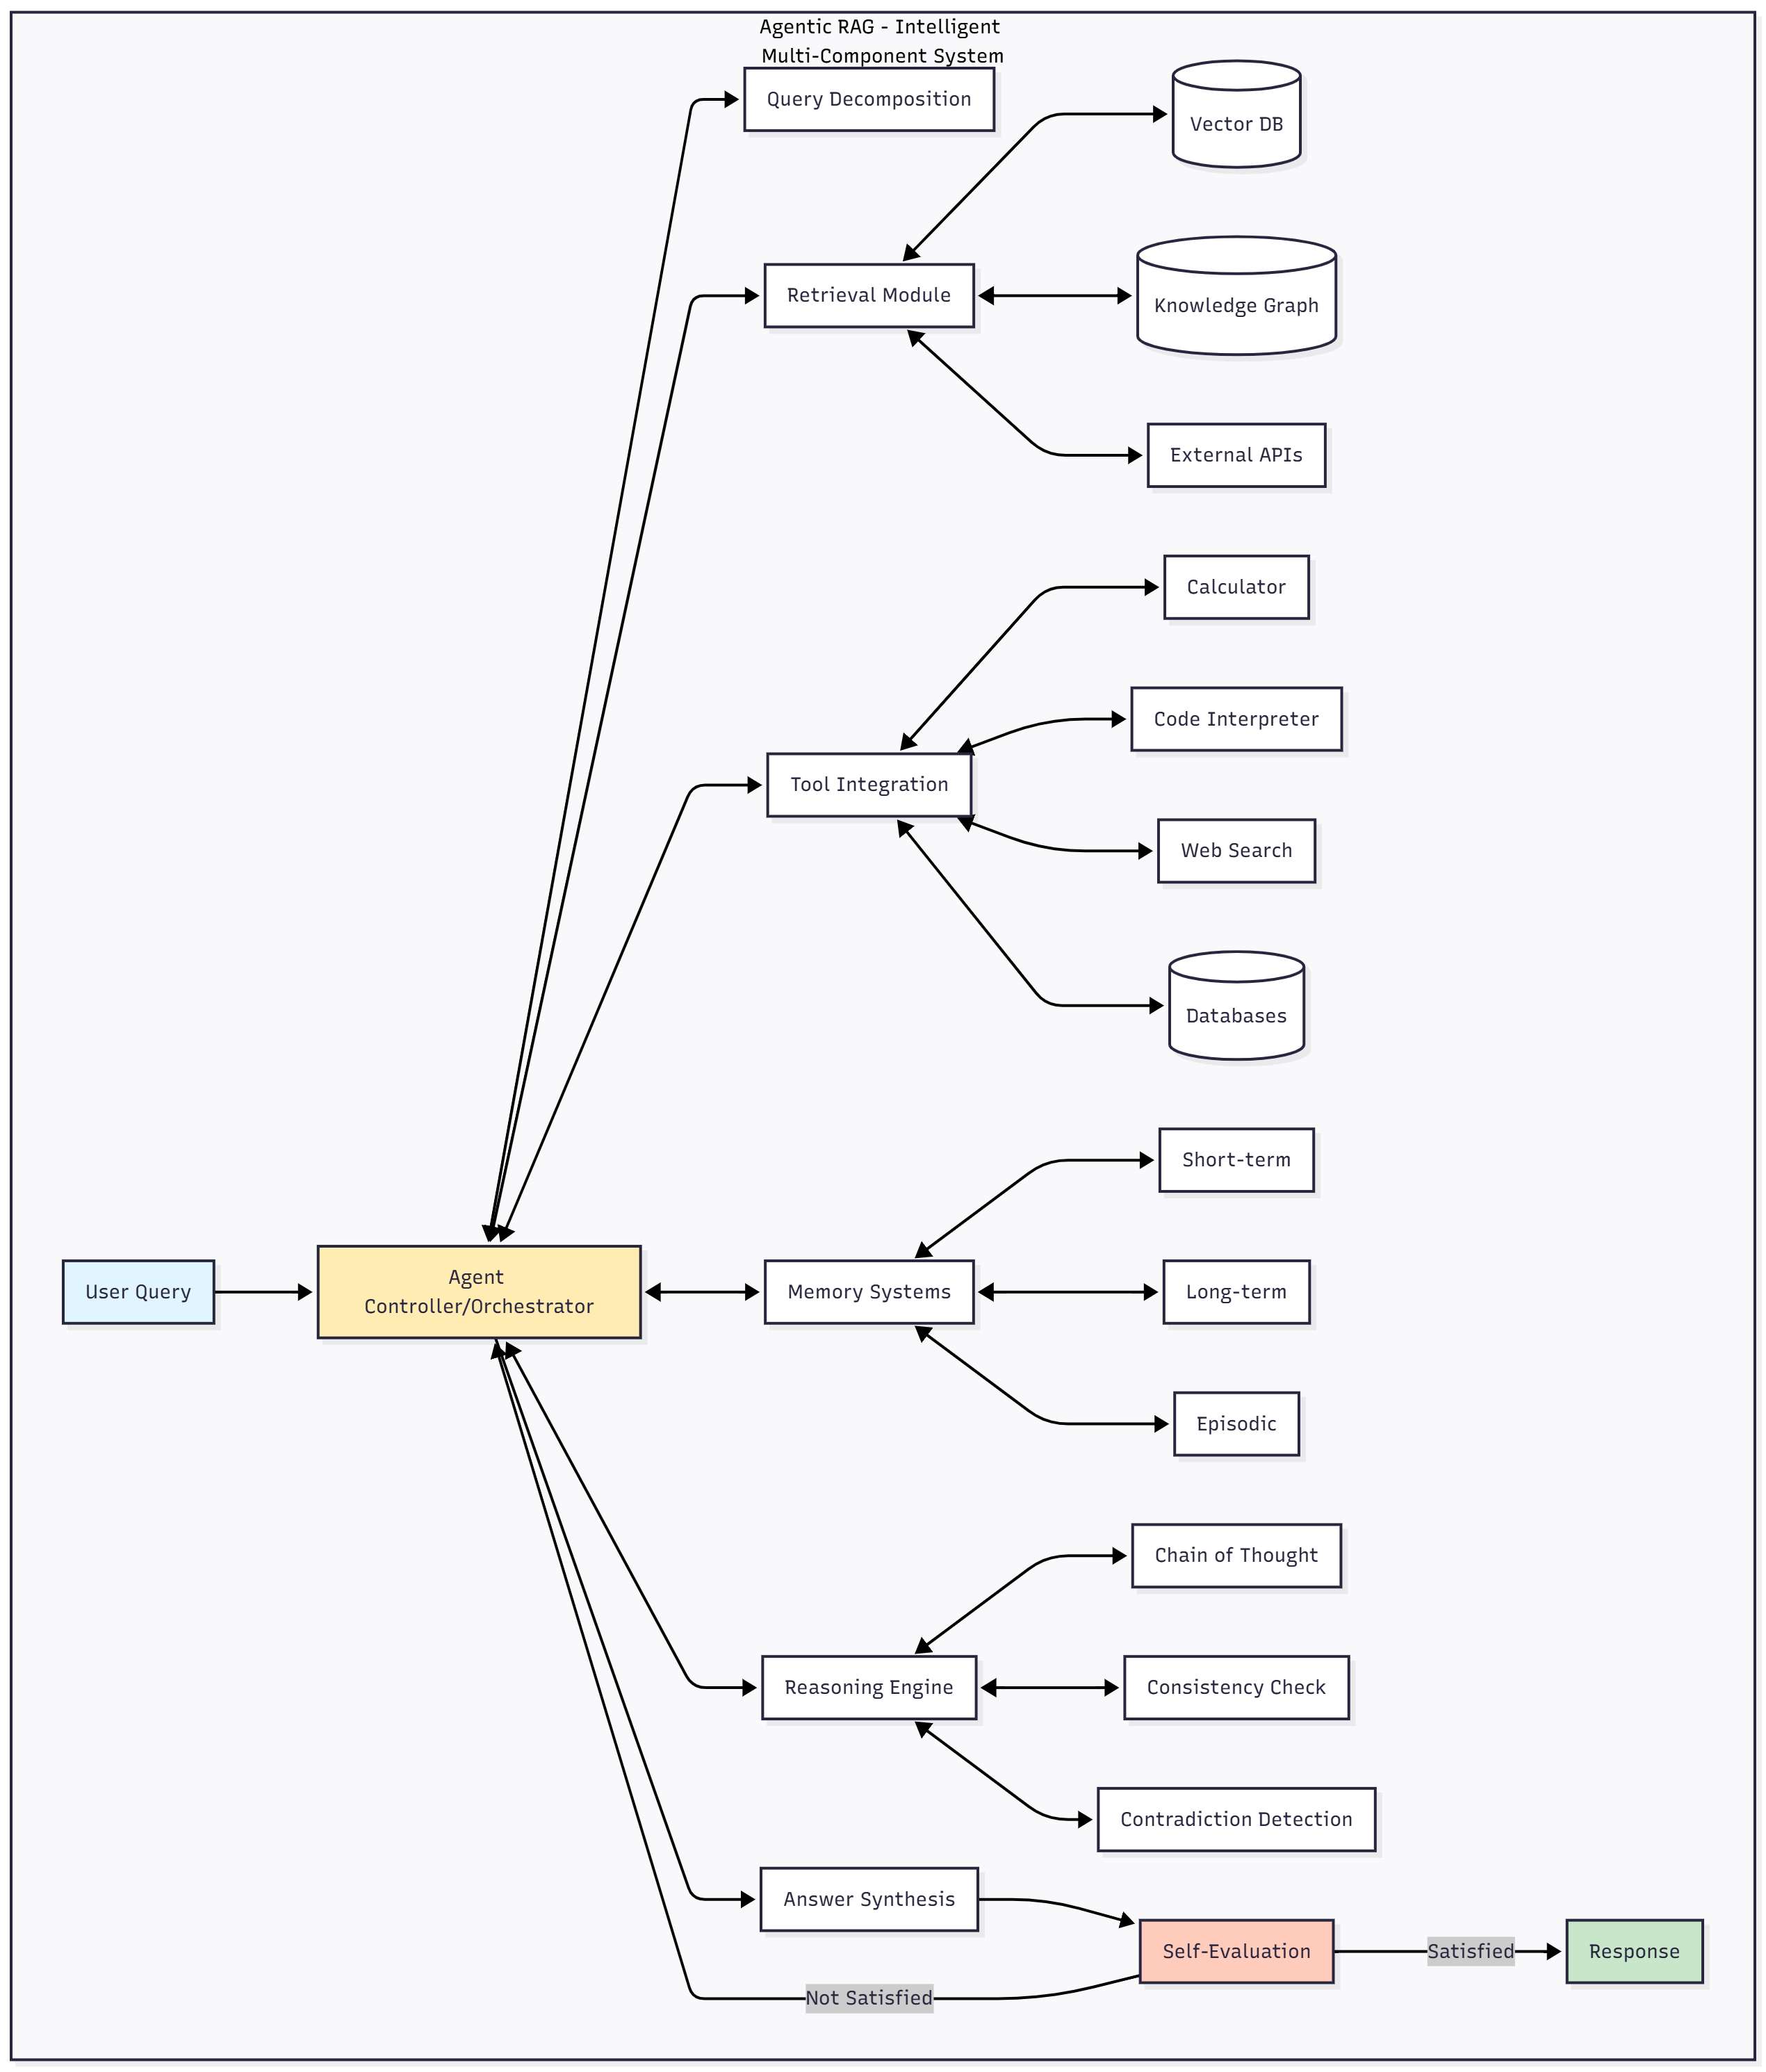


`pseudocode of Agent Controller`

---

```text

CLASS AgentController
    /**
     * Purpose: Central controller for AI agent operations
     * Manages query processing, planning, execution, and validation
     */
    
    ATTRIBUTES:
        llm                  // Language model for reasoning
        tools               // Available tools (retriever, calculator, etc.)
        memory              // Short and long-term memory
        config              // System configuration
        execution_history   // Tracks all actions taken
    

    FUNCTION INITIALIZE(llm, tools, memory, config)
        BEGIN
            this.llm ← llm
            this.tools ← tools
            this.memory ← memory
            this.config ← config
            this.execution_history ← EMPTY_LIST
        END
    END FUNCTION
    
    

    FUNCTION ProcessQuery(query)
        
        BEGIN
            // Step 1: Query Understanding
            query_analysis ← ANALYZE_QUERY(query)
            
            // Step 2: Strategic Planning
            execution_plan ← CREATE_EXECUTION_PLAN(query_analysis)
            
            // Step 3: Plan Execution with Monitoring
            results ← EXECUTE_PLAN_WITH_ADAPTATION(execution_plan)
            
            // Step 4: Answer Synthesis
            answer ← SYNTHESIZE_ANSWER(results)
            
            // Step 5: Quality Assurance
            validated_answer ← VALIDATE_AND_REFINE(answer)
            
            RETURN validated_answer
        END
    END FUNCTION
    
    
    FUNCTION AnalyzeQuery(query)

        BEGIN
            // Construct analysis prompt
            prompt ← """
                Analyze this query and extract:
                1. Primary intent
                2. Information components needed
                3. Complexity (simple/moderate/complex)
                4. Domain context
                5. Potential ambiguities
                
                Query: """ + query
            
            // Get LLM analysis
            analysis ← llm.ANALYZE(prompt)
            
            // Convert to structured format
            query_analysis ← CREATE QueryAnalysis FROM analysis
            
            RETURN query_analysis
        END
    END FUNCTION
    
    
    FUNCTION CreateExecutionPlan(query_analysis)
        
        BEGIN
            // Generate plan based on analysis
            prompt ← """
                Based on this query analysis:
                """ + query_analysis + """
                
                Create a step-by-step execution plan.
                Available tools: """ + tools.LIST()
            
            plan ← llm.GENERATE_PLAN(prompt)
            
            // Store in execution history
            execution_history.APPEND({
                timestamp: CURRENT_TIME(),
                action: "planning",
                details: plan
            })
            
            RETURN plan
        END
    END FUNCTION
    
    
    FUNCTION ExecutePlanWithAdaptation(execution_plan)
        
        BEGIN
            results ← EMPTY_LIST
            
            FOR EACH step IN execution_plan DO
                // Execute the step
                step_result ← EXECUTE_STEP(step)
                
                // Log execution
                execution_history.APPEND({
                    timestamp: CURRENT_TIME(),
                    action: "execution",
                    step: step,
                    result: step_result
                })
                
                // Check if step was successful
                IF step_result.success THEN
                    results.APPEND(step_result)
                ELSE
                    // Adapt: replan or retry
                    adapted_steps ← ADAPT_PLAN(step, step_result.error)
                    
                    FOR EACH adapted_step IN adapted_steps DO
                        adapted_result ← EXECUTE_STEP(adapted_step)
                        results.APPEND(adapted_result)
                    END FOR
                END IF
                
                // Check if we have enough information to proceed
                IF IS_SUFFICIENT(results) THEN
                    BREAK
                END IF
            END FOR
            
            RETURN results
        END
    END FUNCTION
    
    
    FUNCTION SynthesizeAnswer(results)
        
        BEGIN
            prompt ← """
                Synthesize these results into a clear answer:
                """ + results + """
                
                Provide:
                - Direct answer to the question
                - Supporting evidence
                - Clear reasoning
            """
            
            answer ← llm.GENERATE(prompt)
            
            // Store in memory for future reference
            memory.STORE(answer)
            
            RETURN answer
        END
    END FUNCTION
    
    
    FUNCTION ValidateAndRefine(answer)
        
        BEGIN
            // Quality checks
            validation_result ← CHECK_QUALITY(answer)
            
            IF validation_result.is_valid THEN
                RETURN answer
            ELSE
                // Refine answer based on validation feedback
                refined_prompt ← """
                    The answer has these issues:
                    """ + validation_result.issues + """
                    
                    Original answer:
                    """ + answer + """
                    
                    Please refine the answer to address these issues.
                """
                
                refined_answer ← llm.GENERATE(refined_prompt)
                
                RETURN refined_answer
            END IF
        END
    END FUNCTION
    
    
    FUNCTION ExecuteStep(step)

        BEGIN
            tool ← SELECT_TOOL(step.tool_name)
            result ← tool.EXECUTE(step.parameters)
            RETURN result
        END
    END FUNCTION
    
    
    FUNCTION AdaptPlan(failed_step, error)
        BEGIN
            prompt ← """
                This step failed:
                """ + failed_step + """
                Error: """ + error + """
                
                Suggest alternative approach.
            """
            
            alternative_steps ← llm.GENERATE_ALTERNATIVES(prompt)
            RETURN alternative_steps
        END
    END FUNCTION
    
    
    FUNCTION CheckQuality(answer)
        BEGIN
            checks ← {
                is_complete: CHECK_COMPLETENESS(answer),
                is_accurate: CHECK_ACCURACY(answer),
                is_relevant: CHECK_RELEVANCE(answer),
                is_clear: CHECK_CLARITY(answer)
            }
            
            is_valid ← ALL_TRUE(checks.VALUES())
            issues ← GET_FAILED_CHECKS(checks)
            
            RETURN {
                is_valid: is_valid,
                issues: issues
            }
        END
    END FUNCTION

END CLASS

```
---

**2.2.2** <u>**Retrieval Module**</u>

The Retrieval Module provides the system with the ability to access and extract relevant information from both internal and external sources. Modern implementations often use vector databases, which perform embedding-based similarity searches to retrieve semantically related documents. However, more sophisticated systems employ hybrid retrieval, combining dense embeddings with sparse keyword-based methods to improve accuracy and recall. Beyond textual search, the retrieval module may also traverse knowledge graphs, enabling reasoning over structured relationships, or integrate APIs to gather external, real-time data.
This flexible retrieval layer ensures that the agent can dynamically select and combine multiple information sources to construct a more contextually complete understanding of a query.

*Multi-Source Retrieval Architecture*

This architecture is designed to retrieve information from multiple kinds of sources and to adapt its search behavior to the query at hand. It maintains several complementary back-ends: a dense, embedding-based store for semantic similarity; a sparse, keyword-driven index for precise lexical matching; a knowledge-graph interface for traversing entity–relation structure; an engine for querying structured, tabular data; and connectors to external APIs for fresh or specialized information. Treating these as interchangeable instruments allows the system to select the most suitable mechanism or combine several, depending on what the question demands and where the most reliable evidence is likely to be found.

When a query arrives, the system can follow a fixed strategy (e.g., purely semantic or purely lexical), a combined strategy that fuses results from different modalities, or an adaptive strategy that chooses among them based on the query's characteristics. In the combined case, results from different back-ends are rank-fused so that strong signals from either semantic similarity or exact term overlap can elevate a document; this balances recall and precision and reduces the risk that any single retrieval mode dominates the outcome.

Rather than treating retrieval as a one-shot action, the design supports an iterative loop guided by feedback. After an initial pass, the current results are assessed for sufficiency, usefulness, and gaps. If the information seems incomplete, contradictory, or off-target, the query is refined—for example, by adding constraints, expanding terms, or shifting emphasis, and another retrieval pass is executed. Useful documents accumulated from previous iterations are retained, while the process repeats up to a bounded number of steps or until a satisfaction criterion is met. This creates a self-correcting search process that resembles expert research behavior: probe, assess, adjust, and converge.

Finally, the system implicitly manages resources and trade-offs: it limits the number of iterations, balances breadth (exploration across modalities) against depth (exploitation within a promising source), and keeps the returned set to a practical size for downstream reasoning. In effect, retrieval becomes an adaptive, multi-modal decision process rather than a static lookup.

`pseudocode of Multi-Source Retriever`

---

```text

CLASS MultiSourceRetriever

    ATTRIBUTES:
        vector_db          // Dense retrieval (embeddings)
        bm25_index         // Sparse retrieval (keywords)
        knowledge_graph    // Graph-based retrieval
        sql_engine         // Structured data queries
        api_connectors     // External API connections
    
    
    FUNCTION INITIALIZE()
        BEGIN
            vector_db ← CREATE VectorDatabase()
            bm25_index ← CREATE BM25Index()
            knowledge_graph ← CREATE KnowledgeGraph()
            sql_engine ← CREATE SQLEngine()
            api_connectors ← CREATE APIConnectors()
        END
    END FUNCTION
    
    
    FUNCTION Retrieve(query, strategy="adaptive")
        /**
         * Execute retrieval with specified strategy
         * 
         * Strategies:
         * - 'dense': Embedding-based similarity search
         * - 'sparse': Keyword-based BM25 search
         * - 'hybrid': Combination of dense and sparse
         * - 'graph': Knowledge graph traversal
         * - 'structured': SQL queries for structured data
         * - 'adaptive': Auto-select based on query type
         * 
         * Input: query - search query string
         *        strategy - retrieval strategy to use
         * Output: List of retrieved documents
         */
        
        BEGIN
            // Auto-select strategy if adaptive
            IF strategy == "adaptive" THEN
                strategy ← SELECT_STRATEGY(query)
            END IF
            
            // Execute hybrid strategy
            IF strategy == "hybrid" THEN
                // Retrieve from dense (vector) search
                dense_results ← vector_db.SEARCH(query, k=10)
                
                // Retrieve from sparse (keyword) search
                sparse_results ← bm25_index.SEARCH(query, k=10)
                
                // Combine results using Reciprocal Rank Fusion
                combined ← RECIPROCAL_RANK_FUSION([dense_results, sparse_results])
                
                // Return top 10 combined results
                RETURN combined[0:10]
            END IF
            
            // Execute dense strategy
            IF strategy == "dense" THEN
                RETURN vector_db.SEARCH(query, k=10)
            END IF
            
            // Execute sparse strategy
            IF strategy == "sparse" THEN
                RETURN bm25_index.SEARCH(query, k=10)
            END IF
            
            // Execute graph strategy
            IF strategy == "graph" THEN
                RETURN knowledge_graph.TRAVERSE(query)
            END IF
            
            // Execute structured strategy
            IF strategy == "structured" THEN
                RETURN sql_engine.QUERY(query)
            END IF
        END
    END FUNCTION
    
    
    FUNCTION IterativeRetrieval(initial_query, feedback_function)
        
        BEGIN
            documents ← EMPTY_LIST
            query ← initial_query
            max_iterations ← 5
            
            FOR i ← 0 TO max_iterations-1 DO
                // Retrieve documents with current query
                new_docs ← RETRIEVE(query)
                
                // Get feedback on retrieved documents
                feedback ← CALL feedback_function(new_docs, documents)
                
                // Check if retrieval is satisfactory
                IF feedback.is_satisfied THEN
                    BREAK  // Exit loop early
                END IF
                
                // Refine query based on feedback
                query ← REFINE_QUERY(query, feedback)
                
                // Add useful documents to collection
                documents.EXTEND(feedback.useful_docs)
            END FOR
            
            RETURN documents
        END
    END FUNCTION
    
    
    FUNCTION SELECT_STRATEGY(query)

        BEGIN
            // Analyze query type and select appropriate strategy
            // (Implementation depends on query analysis logic)
            RETURN selected_strategy
        END
    END FUNCTION
    
    
    FUNCTION RECIPROCAL_RANK_FUSION(result_lists)

        BEGIN
            combined_scores ← EMPTY_MAP
            k ← 60  // Constant for RRF
            
            FOR EACH result_list IN result_lists DO
                FOR rank, document IN ENUMERATE(result_list) DO
                    score ← 1 / (k + rank + 1)
                    combined_scores[document] ← combined_scores[document] + score
                END FOR
            END FOR
            
            // Sort by combined score (descending)
            sorted_results ← SORT_BY_SCORE(combined_scores, DESCENDING)
            RETURN sorted_results
        END
    END FUNCTION
    
    
    FUNCTION REFINE_QUERY(original_query, feedback)

        BEGIN
            refined_query ← MODIFY_QUERY(original_query, feedback)
            RETURN refined_query
        END
    END FUNCTION

END CLASS

```

---

*Advanced Retrieval Strategies:*

1. Hierarchical Retrieval

The hierarchical retrieval process is designed to balance breadth and depth in information retrieval by progressively refining the search space. Instead of attempting to identify the most relevant results in a single retrieval pass, the system begins with a broad search phase and then drills down into the most promising clusters of results. This approach mirrors the way human researchers explore complex topics. First, we scan widely for relevant areas, then focus attention on specific regions of interest.

In the first stage, the system performs a broad search using the initial user query. This search retrieves a relatively large set of candidate documents (for example, the top 20 results) based on a moderate similarity threshold. The goal at this stage is to cast a wide net and ensure that potentially relevant but diverse information is captured, even if some of it is only loosely related to the query.

Next, the retrieved documents are clustered according to their semantic or topical similarity. Clustering groups documents that discuss related ideas or share common features, effectively segmenting the result space into conceptual regions. This step transforms an undifferentiated list of documents into a structured landscape where different subtopics or perspectives can be identified.

Once the clusters are formed, the retriever performs a targeted deep dive into the most promising clusters, typically the top few that appear most relevant to the original query. For each selected cluster, the system generates a refined query that captures the specific focus or theme of that cluster. It then issues a second retrieval pass, using a higher similarity threshold and a smaller top-k value (for example, retrieving the top 5 documents). This ensures that the second-stage results are more focused, contextually relevant, and fine-grained.

The results from these deeper retrievals are then aggregated into a final set of refined documents. By combining broad initial coverage with selective, high-precision exploration, hierarchical retrieval achieves a balance between exploration and exploitation. It basically explores a wide range of possible contexts and then exploits the most promising ones for detailed evidence or insights.

`pseudocode of Hierarchical Retrieval`

---

```text

FUNCTION HierarchicalRetrieval(query)
    
    BEGIN
        // Stage 1: Broad search to cast a wide net
        broad_docs ← RETRIEVE(query, top_k=20, threshold=0.6)
        
        // Stage 2: Identify clusters in the broad results
        clusters ← CLUSTER_DOCUMENTS(broad_docs)
        
        // Stage 3: Deep dive into top clusters
        refined_docs ← EMPTY_LIST
        
        FOR EACH cluster IN FIRST_3_ELEMENTS(clusters) DO
            // Generate specialized query for this cluster
            cluster_query ← GENERATE_CLUSTER_QUERY(query, cluster)
            
            // Retrieve with higher precision from this cluster
            cluster_results ← RETRIEVE(cluster_query, top_k=5, threshold=0.8)
            
            // Add to refined results
            refined_docs.EXTEND(cluster_results)
        END FOR
        
        RETURN refined_docs
    END
END FUNCTION

---

2. Contrastive Retrieval

The contrastive retrieval process is designed to enhance critical reasoning and balanced information gathering by retrieving evidence from multiple, potentially opposing perspectives. Rather than presenting the user with a single viewpoint or homogeneous set of results, this approach explicitly separates information into supporting, contradicting, and neutral categories relative to a given position or claim. This method aligns with advanced retrieval-augmented reasoning systems that aim to facilitate evidence-based evaluation, debate modeling, and bias reduction in information synthesis.

The process begins with a target query and a specified position (for example, a hypothesis, claim, or stance). The retriever first constructs an augmented query that seeks supporting evidence, documents that align with or reinforce the given position. This stage collects arguments, studies, or factual claims that substantiate the perspective being examined.

Next, the system constructs a contrasting query to gather contradictory evidence, sources that challenge, refute, or present alternative viewpoints to the same position. This step is crucial for enabling balanced reasoning, as it ensures that the system does not rely solely on confirmatory evidence (a phenomenon known as confirmation bias in cognitive science).

Finally, the retriever issues a third, neutral query to collect analytical or descriptive material that neither strongly supports nor opposes the given position. Such neutral analyses often provide contextual, methodological, or explanatory information that helps interpret the debate objectively.

By returning three distinct sets of documents, supporting, contradicting, and neutral, the system provides a contrastive evidence base that can be used for tasks such as argument evaluation, stance detection, or factual verification. This structure encourages the model or human analyst to compare claims across multiple perspectives, improving the depth and fairness of reasoning.

`pseudocode of Contrastive Retrieval`

---

```text

FUNCTION ContrastiveRetrieval(query, position)
    
    BEGIN
        // Step 1: Retrieve evidence that supports the given position
        supporting_evidence ← RETRIEVE(query + "evidence supporting" + position)
        
        // Step 2: Retrieve evidence that contradicts the given position
        contradicting_evidence ← RETRIEVE(query + "evidence against" + position)
        
        // Step 3: Retrieve neutral or balanced analysis
        neutral_evidence ← RETRIEVE(query + "neutral analysis")
        
        // Step 4: Package all perspectives into structured result
        result ← {
            'supporting': supporting_evidence,
            'contradicting': contradicting_evidence,
            'neutral': neutral_evidence
        }
        
        RETURN result
    END
END FUNCTION

---

**2.2.3** <u>**Reasoning Engine**</u>

The Reasoning Engine empowers the agent to analyze, validate, and synthesize the retrieved information rather than merely summarizing it. It employs techniques such as chain-of-thought prompting, where the model explicitly articulates intermediate reasoning steps, and self-consistency checking, which compares multiple reasoning paths to ensure reliability. Additional capabilities include logical inference and contradiction detection, allowing the system to identify gaps, conflicts, or redundancies within the information it processes. This reasoning layer transforms the system from a passive retriever into an active thinker, capable of reflective and structured judgment.

`pseudocode of Reasoning Engine`

---

```text
CLASS ReasoningEngine:
    
    # Constructor
    FUNCTION __init__(llm):
        SET self.llm = llm # The core Large Language Model
        
        # Mapping of strategy names to internal methods
        SET self.reasoning_strategies = {
            'chain_of_thought': self.chain_of_thought_reasoning,
            'tree_of_thought': self.tree_of_thought_reasoning,       # Abstract implementation
            'analogical': self.analogical_reasoning,                 # Abstract implementation
            'causal': self.causal_reasoning,                         # Abstract implementation
            'counterfactual': self.counterfactual_reasoning          # Abstract implementation
        }
    END FUNCTION

    # Main Entry Point for Reasoning
    FUNCTION reason(context: STRING, query: STRING, strategy: STRING = "chain_of_thought"):
        
        SET reasoning_fn = self.reasoning_strategies.GET(strategy)
        
        IF reasoning_fn IS NULL:
            RAISE ValueError(CONCATENATE("Unknown reasoning strategy: ", strategy))
        END IF
        
        # Execute the chosen reasoning strategy function
        RETURN reasoning_fn(context, query)
    END FUNCTION


    FUNCTION chain_of_thought_reasoning(context: STRING, query: STRING):
        
        SET prompt = CONCATENATE(
            "INSTRUCTION: Given the following context, answer the query step by step. Show your reasoning process clearly.",
            "\n\nContext: ", context,
            "\n\nQuery: ", query
        )
        
        # Generate the reasoning and conclusion from the LLM
        SET raw_reasoning_output = self.llm.generate(prompt)
        
        # Post-process the output
        SET steps = self.extract_reasoning_steps(raw_reasoning_output) # Abstract helper
        SET conclusion = self.extract_conclusion(raw_reasoning_output) # Abstract helper
        
        # Package the result
        RETURN ReasoningResult(
            steps=steps,
            conclusion=conclusion,
            confidence=self.assess_confidence(raw_reasoning_output) # Abstract helper
        )
    END FUNCTION


    FUNCTION detect_contradictions(documents: LIST[Document]):
        
        SET contradictions = EMPTY LIST
        
        # Compare every unique pair of documents
        FOR i FROM 0 TO LENGTH(documents) - 2:
            SET doc1 = documents[i]
            FOR j FROM i + 1 TO LENGTH(documents) - 1:
                SET doc2 = documents[j]
                
                # Prompt the LLM to analyze the two documents for conflicting claims
                SET prompt = CONCATENATE(
                    "INSTRUCTION: Analyze these two text segments for contradictions. Identify any factual contradictions, conflicting claims, or incompatible statements.",
                    "\n\nText 1 (Source: ", doc1.source, "): ", doc1.content,
                    "\n\nText 2 (Source: ", doc2.source, "): ", doc2.content
                )
                
                # Assume self.llm.analyze returns a structured object with fields
                SET analysis = self.llm.analyze(prompt) 
                
                IF analysis.has_contradiction IS TRUE:
                    APPEND Contradiction(
                        doc1=doc1,
                        doc2=doc2,
                        description=analysis.contradiction_description,
                        severity=analysis.severity
                    ) TO contradictions
                END IF
            END FOR
        END FOR
        
        RETURN contradictions
    END FUNCTION

```

---

**Reasoning Patterns:**

1. Multi-Hop Reasoning

Multi-hop reasoning refers to the ability of an AI system to answer complex queries that require connecting information across multiple steps or sources, rather than relying on a single direct retrieval. Each hop represents a distinct inferential step, a small piece of reasoning or retrieval that builds upon the previous one, until the system arrives at a complete, coherent answer.

Unlike one-step retrieval (which retrieves a single set of documents most semantically similar to the query), multi-hop reasoning models perform iterative retrieval and inference, where each step uses insights from the last to guide the next query. This enables the system to handle compositional, relational, and contextual questions, especially those that involve entity linking, causality, or implicit relationships spread across multiple data sources.

For example, consider the query:

“Who is the CEO of the company that acquired Twitter?”

A single retrieval step might only return documents about Twitter or X Corp. However, the correct answer requires a chain of dependent facts:

- Hop 1: Identify that Twitter was acquired by X Corp.
- Hop 2: Retrieve information about X Corp to find that it is owned by Elon Musk.
- Hop 3: Infer that Elon Musk is therefore the CEO.

Each step enriches the agent's understanding and refines the next query, mimicking a human's stepwise reasoning process.
This is why multi-hop reasoning is sometimes described as reasoning over chains of evidence or compositional reasoning across knowledge fragments.

Multi-hop reasoning represents a fundamental shift from shallow retrieval to deep cognitive retrieval, enabling Agentic RAG systems to connect disparate knowledge pieces scattered across documents or databases, perform logical composition (A $\rightarrow$ B $\rightarrow$ C reasoning), handle multi-entity, multi-domain, or causal queries, and build transparent reasoning chains, useful for interpretability and explainability. It’s a crucial capability for scientific question answering, knowledge discovery, complex fact-checking, and agentic reasoning, where understanding depends not only on finding information but on connecting and reasoning through it.

`pseudocode of Multi-Hop Reasoning`

---
```text
FUNCTION multi_hop_reasoning(query: STRING, max_hops: INTEGER = 5):
    
    SET reasoning_chain = EMPTY LIST # Stores the key information gathered at each step
    SET current_query = query         # The query for the current retrieval step
    
    # 
    
    FOR hop FROM 1 TO max_hops:
        
        # 1. Retrieve information for the current sub-query/step
        SET docs = self.retriever.retrieve(current_query)
        
        # 2. Extract key facts relevant to the reasoning process
        SET info = self.extract_information(docs, current_query) # Abstract: Uses an LLM to distill retrieved documents
        
        # Record the extracted information as a step in the chain
        APPEND info TO reasoning_chain
        
        # 3. Determine if the reasoning is complete or if a next step is required
        
        # Check if the cumulative evidence answers the original question
        IF self.is_answer_complete(reasoning_chain, query) IS TRUE:
            BREAK # The answer is complete; stop searching
        END IF
        
        # Generate the query for the next required piece of information
        SET next_query = self.identify_next_hop(info, query) # Abstract: Uses LLM to check for missing links
        
        IF next_query IS NULL:
            BREAK # Cannot determine the next step or no further steps are needed
        END IF
        
        # Update the query for the next iteration
        SET current_query = next_query
        
    END FOR
    
    # 4. Synthesize the final answer from the accumulated chain of facts
    RETURN self.synthesize_from_chain(reasoning_chain) # Abstract: Uses an LLM to combine all steps into a cohesive answer
END FUNCTION

```

---

2. Analogical Reasoning

Analogical reasoning is a reasoning pattern in which an agent draws connections between two seemingly different domains, a source domain (where knowledge is well understood) and a target domain (where insight or solutions are being sought). The idea is to transfer principles, structures, or relationships from one context to another based on shared patterns rather than surface similarity. In human cognition, analogical reasoning underlies how we learn new concepts by comparing them to familiar ones.

Examples:

- The structure of the solar system (planets orbiting the sun) has been used as an analogy to explain the Bohr model of the atom (electrons orbiting the nucleus).
- Similarly, in computational or scientific reasoning, principles from biological evolution (selection, mutation, adaptation) can inspire methods in machine learning (genetic algorithms, neural architecture search, evolutionary optimization).

This process allows the agent to leverage prior understanding from a well-modeled source to generate insights in a novel or abstract target domain.

Analogical reasoning enables an Agentic RAG system to move beyond factual retrieval and into creative inference, generating new conceptual knowledge from existing patterns.
While multi-hop reasoning links facts within a domain, analogical reasoning transfers structures across domains. This allows the agent to discover novel hypotheses by drawing parallels between disciplines, generate innovative design ideas (e.g., biomimicry-inspired algorithms), and promote explainability by relating abstract or technical ideas to familiar ones. It’s particularly valuable in scientific discovery, conceptual modeling, and AI creativity, where cross-domain thinking is key to innovation. In other words analogical reasoning allows an Agentic RAG system to think metaphorically but rigorously, learning from one world and applying that understanding to another.

`pseudocode of Analogical Reasoning`

---

```text
FUNCTION analogical_reasoning(query: STRING, source_domain: STRING, target_domain: STRING):
    
    # 1. Retrieve deep information from the Source Domain
    # Search focuses on underlying principles and mechanisms, not just surface facts.
    SET retrieval_query = CONCATENATE(source_domain, " ", query, " principles mechanisms")
    SET source_info = self.retriever.retrieve(retrieval_query)
    
    # 2. Extract key patterns and relational structure
    # This step uses an LLM or an abstract component to generalize the information.
    SET patterns = self.extract_patterns(source_info) # Abstract helper: general rules/mechanisms
    
    # 3. Construct the Analogical Mapping Prompt for the LLM
    SET prompt = CONCATENATE(
        "INSTRUCTION: You will apply a set of patterns from a Source Domain to a Target Domain.",
        "Source Domain: ", source_domain,
        "Target Domain: ", target_domain,
        "Patterns/Principles Extracted: ", patterns,
        
        "\n\nTask:\n",
        "1. Identify the analogous concepts (mapping of entities/objects).",
        "2. Explain how the Source Principles translate to the Target Domain (mapping of relations/mechanisms).",
        "3. List the limitations or disanalogies (where the comparison breaks down)."
    )
    
    # 4. Generate the Analogical Mapping using the LLM
    SET analogical_mapping = self.llm.reason(prompt)
    
    RETURN analogical_mapping
END FUNCTION
```

---

**2.2.4**  <u>**Memory Systems**</u>

Memory within Agentic RAG is typically organized into short-term, long-term, and episodic components, mirroring aspects of human cognition.

- Short-term memory holds the current conversational context and the temporary state of tasks in progress.
- Long-term memory accumulates persistent knowledge, such as learned user preferences, domain-specific data, and prior reasoning patterns.
- Episodic memory records historical interactions and outcomes, enabling the system to learn from experience and adapt behavior over time.

Together, these memory systems provide continuity, enabling the agent to maintain context across sessions and to refine its decision-making with experience.



`pseudocode of Memory System`

---
```text
CLASS MemorySystem:
    
    # Constructor
    FUNCTION __init__():
        # Short-term memory (STM): High capacity, low persistence (e.g., in-context learning buffer)
        SET self.short_term = ShortTermMemory(capacity=50) 
        
        # Long-term memory (LTM): High persistence, high capacity (e.g., vector database)
        SET self.long_term = LongTermMemory(
            storage_backend="vector_db",
            index_type="hierarchical" # For efficient search
        )
        
        # Episodic memory: Contextual events (e.g., "when I did X, the result was Y")
        SET self.episodic = EpisodicMemory()
        
        # Semantic memory: Factual, general knowledge (e.g., knowledge graph)
        SET self.semantic = SemanticMemory()
        
        # Procedural memory: Learned skills and strategies (e.g., successful tool-use sequence)
        SET self.procedural = ProceduralMemory()
    END FUNCTION

    # 1. Storing Information (Learning)
    FUNCTION remember(information: ANY, memory_type: STRING = "auto"):
        
        # Auto-classification based on information type/content
        IF memory_type IS "auto":
            SET memory_type = self.classify_information(information) # Abstract helper
        END IF
        
        IF memory_type IS "short_term":
            CALL self.short_term.store(information)
            
            # Promotion: Immediately transfer important STM content to LTM
            IF self.is_important(information): # Abstract helper
                CALL self.long_term.store(information)
            END IF
            
        ELSE IF memory_type IS "episodic":
            # Package the information with context metadata
            SET episode = Episode(
                content=information,
                context=self.get_current_context(),
                timestamp=CURRENT_TIME(),
                emotional_valence=self.assess_emotional_valence(information) # Abstract: e.g., using sentiment analysis
            )
            CALL self.episodic.store(episode)
            
        ELSE IF memory_type IS "procedural":
            IF information IS Strategy:
                CALL self.procedural.learn_strategy(information)
            END IF
        END IF
    END FUNCTION

    # 2. Retrieving Information (Recall)
    FUNCTION recall(query: STRING, memory_types: LIST[STRING] = NULL):
        
        IF memory_types IS NULL:
            SET memory_types = ["short_term", "long_term", "episodic"]
        END IF
        
        SET memories = EMPTY DICTIONARY
        
        FOR memory_type IN memory_types:
            IF memory_type IS "short_term":
                SET memories["short_term"] = self.short_term.search(query) # Basic keyword/proximity search
            
            ELSE IF memory_type IS "long_term":
                SET memories["long_term"] = self.long_term.semantic_search(
                    query, 
                    k=10, 
                    include_metadata=TRUE
                ) # Vector search for semantic relevance
            
            ELSE IF memory_type IS "episodic":
                SET memories["episodic"] = self.episodic.find_similar(
                    query,
                    similarity_threshold=0.7
                ) # Contextual search for similar past events
            
            ELSE IF memory_type IS "procedural":
                SET memories["procedural"] = self.procedural.get_strategies_for(query) # Strategy matching
            END IF
        END FOR
        
        RETURN memories
    END FUNCTION

    # 3. Memory Consolidation (Background Process)
    FUNCTION consolidate():
        
        # Identify memories flagged as important by STM mechanisms (e.g., recency, frequency, attention score)
        SET important_memories = self.short_term.get_important()
        
        FOR memory IN important_memories:
            
            # Abstract and generalize the memory (e.g., using LLM to summarize/remove noise)
            SET abstracted = self.abstract_memory(memory) # Abstract helper
            
            # Store general knowledge in Long-Term Memory
            CALL self.long_term.store(abstracted)
            
            # Update the Semantic Network (knowledge graph/relations)
            CALL self.semantic.update_network(abstracted)
            
            # Extract any successful processes to be learned as a strategy
            IF strategy := self.extract_strategy(memory): # Strategy extraction helper
                CALL self.procedural.learn_strategy(strategy)
            END IF
            
            # Clear memory from Short-Term Storage (once consolidated)
            CALL self.short_term.forget(memory)
        END FOR
    END FUNCTION

```

---

*Memory-Enhanced Retrieval*

Memory-Enhanced Retrieval refers to a retrieval process that leverages the agent's past experiences to improve the effectiveness, efficiency, and contextual accuracy of current searches. Unlike traditional retrieval systems that treat every query as independent, a memory-enhanced retriever remembers prior queries, strategies, and outcomes, allowing it to learn from history and adapt over time.

This approach is inspired by human cognitive processes, where memory plays a central role in reasoning and decision-making. For example, when solving a familiar type of problem, humans recall past experiences, what worked and what didn’t, and reuse or refine those strategies. In Agentic RAG, the memory-enhanced retriever applies the same principle: it uses episodic memory (records of previous retrieval episodes) and procedural memory (learned strategies) to continuously refine its retrieval behavior.

Memory-Enhanced Retrieval is a cornerstone of adaptive intelligence in Agentic RAG systems. It moves retrieval from a reactive process (responding to each query in isolation) to a reflective and learning-driven process that builds a retrieval history and uses it for continuous improvement, develops a meta-cognitive capability (knowing which strategies are effective), and enables personalization by remembering user preferences and contextual patterns.

This kind of design allows the system to approach human-like information seeking: remembering, adapting, and refining its approach through experience.

Memory-Enhanced Retrieval turns a retrieval system into a learning agent. It doesn't just look for information. It actually remembers how it searched before, learns from that experience, and adjusts its strategy to think and act more intelligently in the future. This makes it a critical enabler of Agentic RAG’s reflective intelligence, bridging retrieval and long-term adaptation.

`pseudocode of Memory-Enhanced Retrieval`

---
```text
FUNCTION memory_enhanced_retrieval(query: STRING):
    
    # 1. Recall relevant past interactions from the memory module
    # 'episodic' memory focuses on past events/interactions
    SET past_interactions = self.memory.recall(
        query, 
        types=["episodic"]
    )
    
    # 2. Extract successful retrieval strategies from the recalled interactions
    SET successful_strategies = [
        interaction.strategy
        FOR interaction IN past_interactions
        IF interaction.was_successful IS TRUE
    ]
    
    # 
    
    # 3. Apply learned strategies or fall back to default
    IF IS_NOT_EMPTY(successful_strategies):
        # Select the most promising strategy (e.g., using frequency, recency, or relevance to the current query)
        SET strategy = self.select_best_strategy(successful_strategies, query) # Abstract helper function
        
        # Execute the retrieval using the selected strategy (e.g., Dense Retrieval, Keyword Search, Multi-Hop)
        SET results = self.apply_strategy(strategy, query) # Abstract helper function
    ELSE:
        # Fall back to a standard/default method if no successful history is found
        SET strategy = "default_retrieval"
        SET results = self.default_retrieval(query) # Abstract helper function
    END IF
    
    # 4. Evaluate the current interaction's success
    SET success_status = self.evaluate_success(results) # Abstract: e.g., based on click-through rate, answer generation quality, or external evaluation
    
    # 5. Learn from this interaction: Store the entire experience in memory
    CALL self.memory.remember(
        Interaction(
            query=query,
            strategy=strategy,
            results=results,
            was_successful=success_status
        )
    )
    
    RETURN results
END FUNCTION

```

---

**2.2.5** <u>**Tool Integration Layer**</u>

The Tool Integration Layer allows the agent to interact with external computational or information resources to extend its functional reach. This layer may include:

- A calculator for performing mathematical operations,
- A code interpreter for data manipulation and analysis,
- Web search capabilities for accessing current information, and
- Database connectors for retrieving structured data from enterprise or research sources.

Through this integration, the agent gains the ability to not only reason about information but also act upon it such as executing queries, calculations, or code as part of its decision-making process.

In essence, Agentic RAG represents the evolution of retrieval-augmented systems from static responders to dynamic, reasoning-driven agents which is capable of retrieving, understanding, reasoning, and acting in a coordinated, intelligent loop.

<span style="color:pink; font-size:18px; font-weight:bold;">Summary</span>

| Component | Core Purpose	| Key Capabilities |
|:----------|:--------------|:-----------------|
| Agent Controller	| Central planner and coordinator | Task decomposition, strategy selection, orchestration |
| Retrieval Module	| Information acquisition	| Vector/hybrid retrieval, knowledge graph traversal, API access |
| Reasoning Engine	| Analytical and logical processing	| Chain-of-thought, self-consistency, contradiction detection |
| Memory Systems	| Context retention and adaptation	| Short-term, long-term, and episodic storage |
| Tool Integration Layer	| Execution and interaction	| Calculator, code interpreter, web search, databases |

<h2 id="theoretical-framework" style="font-size:20px; font-weight:bold;">2.3 Theoretical Framework</h2>

<h3 style="font-size:20px; font-weight:bold;">2.3.1 Query Understanding and Decomposition</h3>

1. <u> Query Decomposition</u>

Query decomposition is grounded in linguistic theory and information science. According to Moldovan et al. (2003) in their work on question decomposition for QA systems, complex queries can be systematically broken down into atomic information needs.

For example, decompose comparative queries can be as follows:

*How does Tesla's autopilot compare to Waymo's self-driving technology in terms of safety and reliability?*

Decomposition:
1. What are Tesla's autopilot safety features?
2. What are Tesla's autopilot reliability metrics?
3. What are Waymo's self-driving safety features?
4. What are Waymo's self-driving reliability metrics?
5. How do the safety features compare?
6. How do the reliability metrics compare?

`pseudocode of Query Decomposer`

---

```text
CLASS QueryDecomposer:
    
    # Constructor
    FUNCTION __init__(llm, nlp_pipeline):
        SET self.llm = llm               # Used for general decomposition/generation
        SET self.nlp = nlp_pipeline      # Used for syntactic and semantic analysis
    END FUNCTION

    # Main Decomposition Function
    FUNCTION decompose(query: STRING):
        
        # Step 1: Syntactic and Semantic Analysis using NLP
        SET parse_tree = self.nlp.parse(query)
        SET entities = self.nlp.extract_entities(query)
        SET relations = self.nlp.extract_relations(query)
        
        # Step 2: Identify Query Type (from a classifier, e.g., the previous one)
        SET query_type = self.classify_query_type(query) # Abstract helper function
        
        # Step 3: Apply a context-specific Decomposition Strategy
        IF query_type IS "comparative":
            SET sub_queries = self.decompose_comparative(query, entities)
        ELSE IF query_type IS "causal":
            SET sub_queries = self.decompose_causal(query, relations) # Abstract
        ELSE IF query_type IS "temporal":
            SET sub_queries = self.decompose_temporal(query, parse_tree) # Abstract
        ELSE IF query_type IS "aggregative":
            SET sub_queries = self.decompose_aggregative(query, entities) # Abstract
        ELSE:
            # Fallback for generic or unknown queries (relies heavily on LLM reasoning)
            SET sub_queries = self.decompose_general(query) # Abstract
        END IF
        
        # Step 4: Identify Dependencies between sub-queries
        SET dependency_graph = self.build_dependency_graph(sub_queries) # Abstract: e.g., using LLM to determine if Q2 needs the answer to Q1
        
        # Step 5: Optimize Execution Order
        SET execution_order = self.topological_sort(dependency_graph) # Standard graph algorithm
        
        # Return the structured result
        RETURN DecomposedQuery(
            original=query,
            sub_queries=sub_queries,
            dependencies=dependency_graph,
            execution_order=execution_order
        )
    END FUNCTION

    FUNCTION decompose_comparative(query: STRING, entities: LIST[Entity]):
        
        SET sub_queries = EMPTY LIST
        
        # Identify the items being compared (e.g., "electric cars", "hydrogen cars")
        SET comparison_entities = [e for e in entities IF e.type IS "comparable"] 
        # Identify the metrics/criteria for comparison (e.g., "speed", "cost")
        SET comparison_criteria = self.extract_criteria(query) # Abstract helper function
        
        # 3.1: Generate information gathering queries (Pre-requisite step)
        FOR entity IN comparison_entities:
            FOR criterion IN comparison_criteria:
                APPEND CONCATENATE("What are ", entity.name, "'s ", criterion, "?") TO sub_queries
            END FOR
        END FOR
        
        # 3.2: Generate the final synthesis/comparison query (Dependent step)
        SET entity_names = JOIN(" and ", [e.name for e in comparison_entities])
        FOR criterion IN comparison_criteria:
             APPEND CONCATENATE("How do ", entity_names, " compare in terms of ", criterion, "?") TO sub_queries
        END FOR
        
        RETURN sub_queries
    END FUNCTION

    FUNCTION build_dependency_graph(sub_queries: LIST[STRING]):
        SET dependency_graph = EMPTY DICTIONARY # Adjacency list/matrix representation
        
        FOR i FROM 1 TO LENGTH(sub_queries):
            SET current_query = sub_queries[i]
            SET prompt = CONCATENATE(
                "INSTRUCTION: Given the following list of queries, which query(s) *must* be answered before Query ", i, ": '", current_query, "'?",
                "List of all queries: ", JOIN(NEWLINE, sub_queries)
            )
            
            # LLM output should be a list of indices/IDs of prerequisite queries
            SET prerequisites = self.llm.generate(prompt) 
            
            SET dependency_graph[i] = prerequisites # Map current query to its required inputs
        END FOR
        
        RETURN dependency_graph
    END FUNCTION

```

---

2. <u> Query Type Classifier</u>

A Query Type Classifier is a mechanism that allows an intelligent retrieval or reasoning system to understand the intent behind a user's query, not just its surface wording.
Instead of treating every question the same way, the classifier categorizes queries into semantic types (such as factual, analytical, comparative, procedural, or evaluative).
This classification helps the agent choose the most suitable reasoning, retrieval, and tool strategies for each kind of question.

- Factual query: “What is climate change?” $\rightarrow$ The user is asking for a definition or straightforward factual description.
- Analytical query: “How does climate change affect global food production?” $\rightarrow$ Requires causal reasoning and the ability to connect multiple variables.
- Comparative query: “How does the impact of climate change differ between coastal and inland regions?” $\rightarrow$ Demands contrastive retrieval across two contexts.
- Procedural query: “How can local governments reduce carbon emissions?” $\rightarrow$ Seeks step-by-step methods or policies.
- Evaluative query: “Is investing in renewable energy an effective way to combat climate change?” $\rightarrow$ Requires judgment-based reasoning supported by evidence.

By recognizing these query types, the Agent Controller can adapt its reasoning process. For example, a factual query might rely on concise retrieval from trusted knowledge bases,
while an analytical or evaluative query would trigger multi-hop reasoning or the integration of external analytical tools.

`pseudocode of Query Type Classifier`

---

```text
CLASS QueryTypeClassifier:
    
    # Constructor
    FUNCTION __init__():
        # Define the set of patterns (regular expressions) for each query type
        SET self.query_patterns = {
            'factual': [
                "what is", "who is", "when did", "where is", "define"
            ],
            'analytical': [
                "why", "how does", "explain", "analyze", "what causes"
            ],
            'comparative': [
                "compare", "difference between", "versus", "vs\.", "better than"
            ],
            'procedural': [
                "how to", "steps to", "procedure for", "instructions for"
            ],
            'evaluative': [
                "should", "is it worth", "evaluate", "assess", "pros and cons"
            ],
            'hypothetical': [
                "what if", "suppose", "imagine", "would happen if"
            ],
            'causal': [
                "because", "due to", "causes", "results in", "leads to"
            ],
            'temporal': [
                "timeline", "history of", "evolution of", "before and after", "chronological"
            ]
        }
    END FUNCTION

    # Main Classification Function
    FUNCTION classify(query: STRING):
        SET query_lower = TO_LOWERCASE(query)
        SET scores = EMPTY DICTIONARY # To hold score for each type
        
        # Step 1: Pattern-based classification
        FOR query_type, patterns IN self.query_patterns:
            SET score = 0
            FOR pattern IN patterns:
                # REGEX_SEARCH checks if the pattern (a regular expression) is found in the query
                IF REGEX_SEARCH(pattern, query_lower) IS TRUE:
                    SET score = score + 1
                END IF
            END FOR
            SET scores[query_type] = score
        END FOR
        
        # Step 2: Check for inconclusive results
        SET max_score = MAX_VALUE(scores.values())
        
        IF max_score < 2:
            # If the best match has a low score, fall back to a more sophisticated method (e.g., LLM)
            RETURN self.llm_classify(query) # Abstract function using an LLM
        END IF
        
        # Step 3: Determine primary and secondary types
        SET primary_type = KEY_WITH_MAX_VALUE(scores)
        SET secondary_types = EMPTY LIST
        
        FOR type, score IN scores.items():
            # Include any type with a non-zero score that is not the primary type
            IF score > 0 AND type IS NOT primary_type:
                APPEND type TO secondary_types
            END IF
        END FOR
        
        # Step 4: Calculate confidence (simple score normalization)
        SET total_patterns = LENGTH(self.query_patterns) 
        SET confidence_score = max_score / total_patterns # Simple measure: max patterns hit / total types
        
        # Return the structured classification result
        RETURN QueryType(
            primary=primary_type,
            secondary=secondary_types,
            confidence=confidence_score
        )
    END FUNCTION

```

---

<h3 style="font-size:20px; font-weight:bold;">2.3.2 Retrieval Strategies: Theoretical Models</h3>

1. <u>Iterative Refinement Model</u>

The Iterative Refinement Retriever (IRR) is a retrieval framework that improves information gathering by continuously revising and refining the query based on what has already been learned. Instead of treating retrieval as a single, one-shot operation, this method performs multiple rounds of retrieval, analysis, and reformulation, progressively converging toward a more accurate and complete understanding of the user’s information need.

This approach is grounded in research such as Xiong et al. (2021), “Answering Complex Open-Domain Questions with Multi-Hop Dense Retrieval”, which showed that iteratively refining queries leads to stronger retrieval performance on complex or multi-hop questions.

Traditional retrieval systems perform only a single query pass, which often misses information when the initial question is ambiguous, under-specified, or requires reasoning across multiple facts. In contrast, the Iterative Refinement Retriever behaves more like a human researcher, who starts with a broad question, reads initial findings, identifies gaps or leads, reformulates the question, and searches again with more precision.

This design enables the system to handle complex, multi-hop, or compositional queries. Additionally, it reduce ambiguity by contextually reformulating queries, accumulate progressive understanding over multiple retrieval cycles and produce higher recall and relevance than one-shot retrieval methods.

`pseudocode of Iterative Refinement Retriever`

---
```text

CLASS IterativeRefinementRetriever:
    # Constructor
    FUNCTION __init__(base_retriever, reranker, llm):
        SET self.base_retriever = base_retriever
        SET self.reranker = reranker
        SET self.llm = llm               # Added LLM for query reformulation
        SET self.max_iterations = 5
        SET self.convergence_threshold = 0.95
    END FUNCTION
    
    # Main Iterative Retrieval Function
    FUNCTION retrieve(query: STRING, context: LIST[STRING] = NULL):
        IF context IS NULL:
            SET context = EMPTY LIST
        END IF
        
        SET all_documents = EMPTY LIST
        SET query_history = [query]
        
        # 
        
        FOR iteration FROM 1 TO self.max_iterations:
            SET current_query = query_history[LAST_INDEX]
            
            # Step 1: Reformulate query for improved retrieval (Skip for first iteration)
            IF iteration > 1:
                SET current_query = self.reformulate_query(
                    original_query=query_history[0],
                    context=context,
                    previous_queries=query_history
                )
                APPEND current_query TO query_history
            END IF
            
            # Step 2: Retrieve new documents using the base retriever
            SET new_docs = self.base_retriever.search(current_query, k=10)
            
            # Filter out documents already retrieved
            SET new_docs = [
                doc for doc in new_docs 
                IF doc.id NOT IN {d.id for d in all_documents}
            ]
            
            IF IS_EMPTY(new_docs):
                BREAK # Stop if no new information is being found
            END IF
            
            # Step 3: Rerank all accumulated documents with the original query and current context
            EXTEND all_documents WITH new_docs
            SET ranked_docs = self.reranker.rerank(
                query=query_history[0],
                documents=all_documents,
                context=context
            )
            
            # Step 4: Check for convergence
            IF self.has_converged(ranked_docs, iteration):
                BREAK # Stop if the top results are stable
            END IF
            
            # Step 5: Update the context with key information from the new best documents
            EXTEND context WITH self.extract_key_information(ranked_docs[:3]) # Abstract helper to summarize top 3 docs
        END FOR
        
        RETURN ranked_docs
    END FUNCTION

    FUNCTION reformulate_query(original_query: STRING, context: LIST[STRING], previous_queries: LIST[STRING]):
            
            # Format the history and context for the LLM prompt
            SET previous_queries_str = JOIN("- ", previous_queries[1:]) # Skip the original query
            SET context_str = JOIN(NEWLINE, context)
            
            SET prompt = CONCATENATE(
                "INSTRUCTION: Given the original query, previous search attempts, and the discovered context,",
                "generate a *new and refined search query* to find missing information.",
                "Original Query: ", original_query,
                "Previous Queries Attempted: ", previous_queries_str,
                "Context Discovered So Far: ", context_str,
                "New Query:"
            )
            
            RETURN self.llm.generate(prompt).trim()
        END FUNCTION

    
    FUNCTION has_converged(documents: LIST[Document], iteration: INTEGER):
        SET TOP_K = 5 # Check stability of the top 5 documents
        SET current_top_docs = {doc.id for doc in documents[:TOP_K]}
        
        IF iteration == 1:
            SET self.previous_top_docs = current_top_docs
            RETURN FALSE
        END IF
        
        # Calculate Jaccard similarity / Overlap ratio
        SET overlap_count = LENGTH(self.previous_top_docs INTERSECT current_top_docs)
        SET overlap_ratio = overlap_count / TOP_K
        
        SET self.previous_top_docs = current_top_docs
        
        RETURN overlap_ratio >= self.convergence_threshold
    END FUNCTION

```

---

2. <u>Multi-Hop Reasoning Model</u>

A Multi-Hop Reasoning Model is a framework that enables an intelligent system to answer complex questions by connecting information across multiple steps or “hops” of reasoning and retrieval. Each hop represents an intermediate stage in which the model retrieves new information, reasons over it, and uses what it has learned to guide the next retrieval. As mentioned above, this process mirrors how humans reason through complex problems. We rarely find an answer immediately. Instead, we gather partial evidence, think about it, and then ask follow-up questions that lead us closer to the final conclusion.

Multi-hop reasoning models address one of the biggest limitations of traditional retrieval-augmented systems which is the inability to handle indirect or compositional questions.
Many real-world queries require connecting multiple facts across documents, such as:

- Causal chains (A causes B, B leads to C)
- Relational queries (entity X related to entity Y through Z)
- Temporal reasoning (event A happened before event B)

By alternating between retrieval and reasoning, the model effectively constructs a chain of thought grounded in evidence, rather than guessing or relying on pattern matching.
This enables explainable, stepwise reasoning, where each hop can be inspected to understand how the model arrived at its answer.

In other words, a Multi-Hop Reasoning Model transforms information retrieval into a stepwise reasoning process. It doesn't just look up an answer. It actually thinks through the problem, gathering and connecting evidence across multiple steps. This makes it a core building block of Agentic RAG, enabling systems to reason like human researchers where we ask, find, think, refine, and conclude.

`pseudocode of Multi-hop Retriever`

---
```text

CLASS MultiHopRetriever:
    # Constructor
    FUNCTION __init__(retriever, reasoner):
        SET self.retriever = retriever
        SET self.reasoner = reasoner
        SET self.max_hops = 3 # Default maximum hops for a question
    END FUNCTION

    # Main Multi-Hop Execution Function
    FUNCTION multi_hop_retrieve(query: STRING):
        SET hops = EMPTY LIST
        SET current_question = query
        SET accumulated_evidence = EMPTY LIST 
        
        # 
        
        # Iterate through the hops
        FOR hop_num FROM 1 TO self.max_hops:
            
            # Step 1: Generate a specific retrieval query for the current hop
            SET retrieval_query = self.generate_retrieval_query(
                current_question,
                accumulated_evidence
            )
            
            # Step 2: Retrieve relevant documents from the knowledge source
            SET documents = self.retriever.search(retrieval_query)
            
            # Step 3: Use the reasoner to process the new evidence and make a step towards the final answer
            SET reasoning_result = self.reasoner.reason(
                question=current_question,
                new_evidence=documents,
                previous_evidence=accumulated_evidence
            )
            
            # Record the details of the current hop
            APPEND Hop(
                question=current_question,
                retrieval_query=retrieval_query,
                documents=documents,
                reasoning=reasoning_result
            ) TO hops
            
            # Step 4: Check for a complete answer and terminate early if found
            IF reasoning_result.has_complete_answer IS TRUE:
                BREAK # Exit the loop, the complex query is answered
            END IF
            
            # Step 5: Update state for the next hop
            IF reasoning_result.next_question IS NOT NULL:
                # The reasoner generated a new sub-question to search for
                SET current_question = reasoning_result.next_question
                ACCUMULATE documents TO accumulated_evidence
            ELSE:
                # The reasoner couldn't break down the problem further or failed
                BREAK
            END IF
        END FOR
        
        # Synthesize and return the final result
        RETURN MultiHopResult(
            hops=hops,
            final_answer=self.synthesize_answer(hops), # Abstract: Combines reasoning steps from all hops
            confidence=self.calculate_confidence(hops) # Abstract: Calculates confidence based on evidence chain
        )
    END FUNCTION

```
---

Generate optimized retrieval query for current hop.

```text
    FUNCTION generate_retrieval_query(question: STRING, evidence: LIST[Document]):
        
        IF IS_EMPTY(evidence) IS TRUE:
            # First hop: retrieval query is just the initial question
            RETURN question
        END IF
        
        # Subsequent hops: LLM refines the search query based on previous results
        SET summarized_evidence = self.summarize_evidence(evidence) # Abstract helper function
        
        # Prompt the LLM to generate the next search query
        SET prompt = CONCATENATE(
            "INSTRUCTION: Given the current question and the evidence gathered so far, ",
            "generate the next *precise search query* needed to find the missing information.",
            "Current Question: ", question,
            "Evidence gathered so far: ", summarized_evidence,
            "Search Query:"
        )
        
        RETURN self.reasoner.llm.generate(prompt).trim()
    END FUNCTION

```

<h3 style="font-size:20px; font-weight:bold;">2.3.3 Citation and Attribution Framework</h3>

A Citation and Attribution Framework ensures that every statement an AI system generates can be traced back to verifiable sources. It introduces transparency, accountability, and factual grounding into language model generation, turning a black-box model into an auditable, evidence-based reasoning system. This framework is a key part of trustworthy and explainable AI. It allows both developers and users to see where the model got its information and how confident it is about each claim.

In short, attribution transforms AI output from “I think” to “According to Source [1], here’s why…”

This framework addresses two of the biggest weaknesses of generative AI:

1. Hallucination: when a model fabricates facts that sound plausible but aren't true.
2. Opacity: when users cannot tell where a statement came from.

By forcing the model to generate attributable and verifiable content, the system actually improves factual reliability, increases user trust, enables post-hoc auditing, and supports scientific, journalistic, and enterprise-grade applications that demand evidence-based outputs.

`pseudocode of Citation and Attribution`

---
```text

CLASS AttributedGenerator:
    # Constructor
    FUNCTION __init__(llm, citation_style="inline"):
        SET self.llm = llm
        SET self.citation_style = citation_style
    END FUNCTION

    # Main Generation Function
    FUNCTION generate_with_attribution(query: STRING, documents: LIST[Document]):
        # 1. Extract claims from documents, mapping claims to their source Document ID
        SET claims_with_sources = self.extract_claims(documents)
        
        # 2. Build a prompt that includes the query and the available claims/context
        SET prompt = self.build_attribution_prompt(query, claims_with_sources)
        
        # 3. Generate the response using the LLM
        SET raw_response = self.llm.generate(prompt)
        
        # 4. Post-process to ensure proper, verifiable citations (if LLM didn't perfectly follow instruction)
        SET attributed_response = self.add_citations(raw_response, claims_with_sources) # Assumes this is a helper function
        
        # 5. Verify the attribution accuracy (Are the citations correct and supporting the text?)
        SET verification_result = self.verify_attributions(attributed_response, documents)
        
        # 6. Generate a measure of the model's confidence in each claim
        SET confidence_scores = self.calculate_claim_confidence(attributed_response, documents) # Assumes this is a helper function
        
        # Return the structured result
        RETURN AttributedResponse(
            text=attributed_response,
            citations=self.extract_citations(attributed_response),
            verification=verification_result,
            confidence_scores=confidence_scores
        )
    END FUNCTION


FUNCTION build_attribution_prompt(query: STRING, claims: LIST[ClaimWithSource]):
        SET formatted_claims = self.format_claims_for_prompt(claims) # Converts List[ClaimWithSource] to a formatted string
        
        RETURN CONCATENATE(
            "INSTRUCTION: Answer the following question *ONLY* using the 'Available Information'.",
            "Cite the source ID (e.g., [Doc_1]) immediately after every factual claim.",
            "Question: ", query,
            "Available Information: ", formatted_claims,
            "Response:"
        )
    END FUNCTION


FUNCTION verify_attributions(response: STRING, documents: LIST[Document]):
        # Extract all claims and their corresponding inline citations from the response
        SET claims = self.extract_claims_from_response(response) 
        
        SET verification_results = EMPTY LIST
        
        FOR claim IN claims:
            # Check 1: Is a citation present?
            IF claim.citation IS NULL:
                APPEND ClaimVerification(claim=claim, status="missing_citation", confidence=0.0) TO verification_results
                CONTINUE
            END IF
            
            # Check 2: Is the cited source valid?
            SET source_doc = self.get_document_by_id(claim.citation, documents)
            
            IF source_doc IS NULL:
                APPEND ClaimVerification(claim=claim, status="invalid_source", confidence=0.0) TO verification_results
                CONTINUE
            END IF
            
            # Check 3: Does the cited source support the claim? (Requires a fact-checking model or NLI)
            SET support_check = self.check_claim_support(
                claim.text,
                source_doc.content
            )
            
            # Append final verification status
            APPEND ClaimVerification(
                claim=claim,
                status=support_check.status, # e.g., "supported", "refuted", "neutral"
                confidence=support_check.confidence
            ) TO verification_results
        END FOR
        
        RETURN VerificationResult(
            verifications=verification_results,
            overall_accuracy=self.calculate_overall_accuracy(verification_results) # e.g., proportion of 'supported' claims
        )
    END FUNCTION

```
---

<h3 style="font-size:20px; font-weight:bold;">2.3.4 Comprehensive Self-Evaluation Framework</h3>

A Self-Evaluation Framework enables an AI system to assess the quality, reliability, and completeness of its own outputs, without needing a human reviewer in the loop.
It is, in essence, a metacognitive layer: the model doesn't just produce an answer; it reflects on that answer, checks its reasoning, and identifies possible errors or gaps. This design aligns with ideas from Kadavath et al. (2022) (“Language Models (Mostly) Know What They Know”) and Manakul et al. (2023) (“SelfCheckGPT”), which showed that language models can often detect their own hallucinations or uncertainties when prompted in the right way. 

In an Agentic RAG setting, the self-evaluation framework is a self-correction mechanism by improving both factual reliability and epistemic confidence before a response is finalized or presented to the user.

The Self-Evaluation Framework addresses a crucial problem in large language models which is they can be confidently wrong.

By embedding self-evaluation, the system becomes aware of its uncertainty and can flag low-confidence outputs. Besides, its responses become more trustworthy, verifiable, and complete. Additionally, the agent develops a form of metacognition which is the ability to reason about its own reasoning. This self-critical process transforms the model from a “text generator” into a reflective decision-maker, capable of diagnosing its own mistakes before acting on them.

`pseudocode of Self-Evaluation`

---

```text

CLASS SelfEvaluator:
    # Constructor
    FUNCTION __init__(llm):
        SET self.llm = llm
        SET self.evaluation_methods = {
            'consistency': self.check_consistency,
            'completeness': self.check_completeness,
            'factuality': self.check_factuality,
            # 'relevance': self.check_relevance, 
            # 'confidence': self.assess_confidence
        }
    END FUNCTION

    # Main Evaluation Function
    FUNCTION evaluate_response(response: STRING, query: STRING, context: LIST[Document]):
        SET evaluations = EMPTY DICTIONARY
        
        # Run all evaluation methods
        FOR method_name, method IN self.evaluation_methods:
            SET evaluations[method_name] = method(response, query, context)
        END FOR
        
        # Aggregate scores
        SET overall_score = self.aggregate_scores(evaluations)
        
        # Identify specific issues (abstract method)
        SET issues = self.identify_issues(evaluations)
        
        # Generate improvement suggestions (abstract method)
        SET suggestions = self.generate_suggestions(issues)
        
        RETURN EvaluationResult(
            overall_score=overall_score,
            component_scores=evaluations,
            issues=issues,
            suggestions=suggestions
        )
    END FUNCTION

    FUNCTION check_consistency(response: STRING, query: STRING, context: LIST[Document]):
            SET variations = EMPTY LIST
            SET NUM_VARIATIONS = 3
            
            # Generate multiple rephrased variations
            FOR i FROM 1 TO NUM_VARIATIONS:
                SET prompt = CONCATENATE(
                    "Rephrase the following response while maintaining all factual content:", 
                    response, 
                    "Rephrased version:"
                )
                APPEND self.llm.generate(prompt) TO variations
            END FOR
            
            # Check for consistency across variations
            SET consistency_scores = EMPTY LIST
            FOR i FROM 0 TO LENGTH(variations) - 2:
                FOR j FROM i + 1 TO LENGTH(variations) - 1:
                    # Use a semantic similarity metric (e.g., BERTScore, cosine similarity on embeddings)
                    SET score = self.semantic_similarity(variations[i], variations[j])
                    APPEND score TO consistency_scores
                END FOR
            END FOR
            
            # Check for self-contradiction (abstract LLM analysis)
            SET contradiction_check = self.check_self_contradiction(response)
            
            RETURN ConsistencyScore(
                semantic_consistency=AVERAGE(consistency_scores),
                has_contradictions=contradiction_check.has_contradictions,
                contradiction_details=contradiction_check.details
            )
        END FUNCTION

    FUNCTION check_completeness(response: STRING, query: STRING, context: LIST[Document]):
        # Decompose query into required components (e.g., LLM-based decomposition)
        SET required_components = self.extract_query_components(query)
        
        SET addressed_components = EMPTY LIST
        SET missing_components = EMPTY LIST
        
        # Check each component against the response
        FOR component IN required_components:
            SET prompt = CONCATENATE(
                "Does this response address the following aspect of the query? Aspect:", 
                component, 
                "Response:", 
                response, 
                "Answer (yes/no) and explain:"
            )
            
            # Use LLM to analyze and check the component's presence
            SET check = self.llm.analyze(prompt)
            
            IF check.addressed IS TRUE:
                APPEND component TO addressed_components
            ELSE:
                APPEND component TO missing_components
            END IF
        END FOR
        
        # Calculate completeness score
        IF LENGTH(required_components) > 0:
            SET completeness = LENGTH(addressed_components) / LENGTH(required_components)
        ELSE:
            SET completeness = 1.0 # Trivial completeness if no components
        END IF
        
        RETURN CompletenessScore(
            score=completeness,
            addressed=addressed_components,
            missing=missing_components
        )
    END FUNCTION

    FUNCTION check_factuality(response: STRING, query: STRING, context: LIST[Document]):
        # Extract all verifiable factual claims from the response (LLM or NLP method)
        SET claims = self.extract_factual_claims(response)
        
        SET verified_claims = EMPTY LIST
        SET unverified_claims = EMPTY LIST
        SET false_claims = EMPTY LIST
        
        # Verify each claim
        FOR claim IN claims:
            # Check against context documents (LLM or separate verifier module)
            SET verification = self.verify_claim_against_context(claim, context)
            
            IF verification.status IS "verified":
                APPEND claim TO verified_claims
            ELSE IF verification.status IS "unverified":
                APPEND claim TO unverified_claims
            ELSE IF verification.status IS "false":
                APPEND claim TO false_claims
            END IF
        END FOR
        
        # Calculate factuality score (proportion of verified claims)
        IF LENGTH(claims) > 0:
            SET factuality = LENGTH(verified_claims) / LENGTH(claims)
        ELSE:
            SET factuality = 1.0 # No claims to verify, so perfectly factual
        END IF
        
        RETURN FactualityScore(
            score=factuality,
            verified_claims=verified_claims,
            unverified_claims=unverified_claims,
            false_claims=false_claims,
            total_claims=LENGTH(claims)
        )
    END FUNCTION

```
---

<h1 id="implementation-and-technical-deep-dive" style="font-size:23px; font-weight:bold;">3. Implementation and Technical Deep Dive</h1>

<h2 id="implementation-patterns" style="font-size:20px; font-weight:bold;">3.1 Implementation Patterns</h2>

<h3 style="font-size:20px; font-weight:bold;">3.1.1 Pattern 1: ReAct (Reasoning + Acting)</h3>

The ReAct (Reasoning + Acting) framework, introduced by Yao et al. (2023), represents a major step in building autonomous reasoning agents. Its core idea is that large language models (LLMs) should not only think (reason internally) or act (use tools externally), but interleave both processes in a single, iterative loop. In other words, ReAct agents think step-by-step, decide what to do next, execute that action using available tools (like search, lookup, or calculation), and then observe the results to inform their next reasoning step. This continuous feedback loop as Reason $\rightarrow$ Act $\rightarrow$ Observe $\rightarrow$ Reason again, allows the agent to solve complex, multi-step tasks that require planning, evidence gathering, and dynamic adjustment.

Traditional LLMs (like GPT) can reason in text (“chain-of-thought reasoning”) but can’t directly interact with the world or external data sources. Conversely, tool-augmented models (like Toolformer or AutoGPT) can act. For example, call APIs or search the web, but often act without structured reasoning, leading to errors or inefficient behavior. ReAct basically bridges this gap. It combines symbolic reasoning (thoughts) with external actions (tool use), creating a closed reasoning-action loop that mimics human problem-solving.

ReAct (Reasoning + Acting) is a framework that lets AI agents think like humans, not just generate text, but plan, act, reflect, and revise. It fuses reasoning (the “mind”) with action (the "hands"), enabling the agent to solve complex, multi-step problems with intelligence, adaptability, and transparency. It is, quite literally, a model that doesn't just "react". Instead, it ReActs intelligently.


`pseudocode of ReAct (Reasoning + Acting) — Yao et al., 2023`

---

```text

ENUM ActionType = { SEARCH, LOOKUP, CALCULATE, FINISH }

STRUCT Thought:
  content: string          // the reasoning step
  confidence: float        // model's self-assessed confidence
  timestamp: string

STRUCT Action:
  type: ActionType         // what to do next
  parameters: map          // e.g., {"query": "..."} or {"expression": "..."}
  thought_basis: string    // which thought motivated this action

STRUCT Observation:
  content: string          // result text (top snippets, definition, calc result)
  source: string?          // "search" | "lookup" | "calculator" | null
  reliability: float       // crude trust score

CLASS ReActAgent:
  FIELDS:
    llm                     // large language model
    tools                   // {"search": SearchTool, "lookup": LookupTool, "calculator": CalcTool}
    max_steps: int = 10
    execution_trace: list<(label, any)> = []  // [("thought", Thought), ("action", Action), ("observation", Obs), ...]

  CONSTRUCTOR(llm, tools, max_steps=10):
    SET fields

  METHOD solve(task: string) -> string:
    execution_trace <- []
    context <- "Task: " + task + "\n"

    FOR step FROM 1 TO max_steps:
      // 1) THINK
      thought <- think(context)
      APPEND ("thought", thought) TO execution_trace
      context <- context + "\nThought " + STR(step) + ": " + thought.content

      // 2) ACT (decide tool + params)
      action <- act(thought, context)
      APPEND ("action", action) TO execution_trace

      // early finish
      IF action.type == FINISH:
        RETURN extract_answer(action.parameters["answer"])

      context <- context + "\nAction " + STR(step) + ": " + STR(action.type) + " - " + STR(action.parameters)

      // 3) EXECUTE
      observation <- execute_action(action)
      APPEND ("observation", observation) TO execution_trace
      context <- context + "\nObservation " + STR(step) + ": " + observation.content

      // 4) CAN WE ANSWER NOW?
      IF can_answer(context, task):
        // (optional) one last thought to organize the final answer
        _ <- think(context + "\nNow I need to provide the final answer.")
        RETURN generate_final_answer(task, context)

    // 5) OUT OF STEPS — return the best partial answer
    RETURN generate_partial_answer(task, context)

  METHOD think(context: string) -> Thought:
    prompt <- context + "\n\nBased on the above context, provide the next reasoning step.\n\nThought:"
    content <- llm.generate(prompt).trim()
    confidence <- assess_thought_confidence(content, context)
    RETURN Thought(content=content, confidence=confidence, timestamp=get_timestamp())

  METHOD act(thought: Thought, context: string) -> Action:
    prompt <- "Current thought: " + thought.content + "\n\nContext:\n" + context + "\n\n" +
              "Choose one: search[query] | lookup[term] | calculate[expression] | finish[answer]\n\nAction:"
    action_str <- llm.generate(prompt).trim()
    action <- parse_action(action_str)
    action.thought_basis <- thought.content
    RETURN action

  METHOD execute_action(action: Action) -> Observation:
    SWITCH action.type:
      CASE SEARCH:
        q <- action.parameters.get("query", "")
        results <- tools["search"].search(q)
        IF results not empty:
          content <- format_search_results(results[0..2])
          reliability <- assess_source_reliability(results[0].source)
        ELSE:
          content <- "No relevant results found."
          reliability <- 0.0
        RETURN Observation(content, "search", reliability)

      CASE LOOKUP:
        term <- action.parameters.get("term", "")
        defn <- tools["lookup"].get_definition(term)
        IF defn:
          RETURN Observation(defn, "lookup", 0.9)
        ELSE:
          RETURN Observation("No definition found for '" + term + "'", "lookup", 0.0)

      CASE CALCULATE:
        expr <- action.parameters.get("expression", "")
        TRY:
          val <- tools["calculator"].evaluate(expr)
          RETURN Observation("Calculation result: " + STR(val), "calculator", 1.0)
        CATCH e:
          RETURN Observation("Calculation error: " + STR(e), "calculator", 0.0)

      DEFAULT:
        RETURN Observation("Unknown action type", null, 0.0)

  METHOD parse_action(action_str: string) -> Action:
    // expected "verb[argument]"; robust fallback to SEARCH
    (verb, arg) <- PARSE_BRACKET_FORM(action_str.lower())   // e.g., ("search", "capital of japan")
    IF verb == null:
      RETURN Action(type=SEARCH, parameters={"query": action_str}, thought_basis="")
    MAP <- {"search": SEARCH, "lookup": LOOKUP, "calculate": CALCULATE, "finish": FINISH}
    atype <- MAP.get(verb, SEARCH)
    params <-
      IF atype == SEARCH:     {"query": arg}
      ELSE IF atype == LOOKUP:    {"term": arg}
      ELSE IF atype == CALCULATE: {"expression": arg}
      ELSE IF atype == FINISH:    {"answer": arg}
      ELSE: {"value": arg}
    RETURN Action(type=atype, parameters=params, thought_basis="")

  METHOD can_answer(context: string, task: string) -> bool:
    prompt <- "Task: " + task + "\n\nCurrent Context:\n" + context +
              "\n\nDo we have enough verified information for a complete answer? (yes/no + brief reason)"
    resp <- llm.generate(prompt).lower().trim()
    RETURN resp STARTS WITH "yes"

  METHOD generate_final_answer(task: string, context: string) -> string:
    prompt <- "Task: " + task + "\n\nUsing the reasoning and observations below:\n" +
              context + "\n\nProvide a clear, concise final answer.\n\nFinal Answer:"
    RETURN llm.generate(prompt).trim()

  // SUPPORT METHODS (signatures only; implementation depends on your stack)
  METHOD extract_answer(text) -> string
  METHOD generate_partial_answer(task, context) -> string
  METHOD assess_thought_confidence(thought, context) -> float
  METHOD get_timestamp() -> string
  METHOD format_search_results(results) -> string
  METHOD assess_source_reliability(source) -> float
  METHOD PARSE_BRACKET_FORM(s) -> (verb, arg)

------------------------------------------------------------

FUNCTION demonstrate_react():
  tools <- {
    "search": MockSearchTool(),
    "lookup": MockLookupTool(),
    "calculator": MockCalculatorTool()
  }
  agent <- ReActAgent(llm=MockLLM(), tools=tools, max_steps=10)

  question <- "What is the difference in population density between Tokyo and New York City, " +
              "and how does this compare to the global average urban population density?"
  answer <- agent.solve(question)

  PRINT "Question:", question
  PRINT "Answer:", answer
  PRINT "Execution Trace:"
  FOR (label, entry) IN agent.execution_trace:
    PRINT UPPER(label) + ":", entry

```
---

<h3 style="font-size:20px; font-weight:bold;">3.1.2 Pattern 2: Plan-and-Execute</h3>

In the Plan-and-Execute paradigm, an agent first builds a global plan, an ordered set of steps with explicit dependencies and expected outputs, then executes those steps while monitoring progress, handling failures, and, when necessary, re-planning. This contrasts with interleaved styles such as ReAct, as Plan-and-Execute emphasizes front-loaded structure: the agent determines what must be done and in what order before acting. This approach is particularly effective for complex, multi-criteria tasks (e.g., research projects, data pipelines, or multi-API workflows) where coordination, reproducibility, and traceability are essential.

Plan-and-Execute works best for long-horizon, multi-constraint problems such as comparative literature reviews, cross-system analyses, or multi-stage data processing, whereas ReAct excels in exploratory or uncertain settings that require the agent to pivot dynamically after each observation. However, the Plan-and-Execute method also faces several challenges. Over-planning can occur when the initial plan proves brittle or unrealistic; this can be mitigated by introducing early, small "probe" steps and periodic adapt/replan checks. Plan drift may also arise when real outputs deviate from expected results, necessitating the use of confidence thresholds and output validation to control progress. Finally, dependency cycles can hinder execution and must be detected and resolved through intelligent plan restructuring.

`pseudocode of Plan-and-Execute (Wang et al. 2023; Sun et al. 2023)`

---

```text

ENUM StepStatus = { PENDING, IN_PROGRESS, COMPLETED, FAILED, SKIPPED }

STRUCT PlanStep:
  id: string
  description: string
  action: string                // e.g., "search", "analyze", "compare", "calculate", "synthesize"
  dependencies: list<string>    // other step ids that must complete first
  expected_output: string
  status: StepStatus = PENDING
  result: any = null
  error: string = null

STRUCT ExecutionPlan:
  goal: string
  steps: list<PlanStep>
  metadata: map<string, any> = {}

  METHOD get_step_by_id(step_id):
    RETURN first step in steps with id == step_id OR null

  METHOD get_ready_steps():
    ready <- []
    FOR each step IN steps:
      IF step.status == PENDING:
        deps_completed <- TRUE
        FOR dep_id IN step.dependencies:
          dep <- get_step_by_id(dep_id)
          IF dep == null OR dep.status != COMPLETED:
            deps_completed <- FALSE
        IF deps_completed:
          APPEND step TO ready
    RETURN ready

  METHOD is_complete():
    RETURN ALL(step.status IN {COMPLETED, SKIPPED} FOR step IN steps)


CLASS PlanAndExecuteAgent:
  FIELDS:
    llm
    tools                     // e.g., {"search": SearchTool, "calculator": Calculator}
    max_replanning: int = 3
    execution_history: list = []   // [(label, plan_snapshot), ...]

  CONSTRUCTOR(llm, tools, max_replanning = 3):
    SET fields accordingly

  METHOD solve(task: string) -> string:
    plan <- generate_plan(task)
    APPEND ("initial_plan", plan) TO execution_history

    replans <- 0
    WHILE NOT plan.is_complete() AND replans < max_replanning:
      ready_steps <- plan.get_ready_steps()

      IF ready_steps is empty:
        IF needs_replanning(plan):
          plan <- replan(plan, task)
          replans += 1
          APPEND ("replan", plan) TO execution_history
        ELSE:
          // deadlock: mark remaining pending as failed
          FOR step IN plan.steps:
            IF step.status == PENDING:
              step.status <- FAILED
              step.error  <- "Deadlock detected"
          BREAK

      // execute all steps that are ready (could be parallel in practice)
      FOR step IN ready_steps:
        execute_step(step, plan)

      // optional adaptive planning based on results
      IF should_adapt_plan(plan):
        plan <- adapt_plan(plan, task)
        APPEND ("adapted_plan", plan) TO execution_history

    RETURN synthesize_answer(task, plan)

  METHOD generate_plan(task: string) -> ExecutionPlan:
    prompt <- "Create JSON plan: goal + steps(id, description, action, dependencies, expected_output)"
    plan_json <- llm.generate(prompt, output_format="json")
    plan_data <- PARSE_JSON(plan_json)
    steps <- []
    FOR s IN plan_data.steps:
      APPEND PlanStep(
        id = s.id,
        description = s.description,
        action = s.action,
        dependencies = s.dependencies OR [],
        expected_output = s.expected_output
      ) TO steps
    RETURN ExecutionPlan(goal = plan_data.goal, steps = steps, metadata = {"original_task": task})

  METHOD execute_step(step: PlanStep, plan: ExecutionPlan):
    step.status <- IN_PROGRESS
    TRY:
      context <- gather_context(step, plan)      // collect outputs of completed dependencies
      SWITCH step.action:
        CASE "search":
          result <- execute_search(step, context)
        CASE "analyze":
          result <- execute_analysis(step, context)
        CASE "compare":
          result <- execute_comparison(step, context)
        CASE "calculate":
          result <- execute_calculation(step, context)
        CASE "synthesize":
          result <- execute_synthesis(step, context)
        DEFAULT:
          result <- execute_generic(step, context)
      step.result <- result
      step.status <- COMPLETED
    CATCH e:
      step.status <- FAILED
      step.error  <- STRING(e)

  METHOD execute_search(step, context) -> any:
    query <- extract_search_query(step.description, context)
    results <- tools["search"].search(query, k=5)
    summary <- summarize_search_results(results, step.expected_output)
    RETURN { "query": query, "results": results, "summary": summary }

  METHOD execute_analysis(step, context) -> any:
    prompt <- "Perform analysis:\n" + step.description + "\nContext:\n" + PRETTY(context) + "\nExpected: " + step.expected_output
    analysis <- llm.generate(prompt)
    RETURN { "analysis": analysis, "confidence": assess_confidence(analysis) }

  // (execute_comparison, execute_calculation, execute_synthesis, execute_generic) similarly shape outputs

  METHOD needs_replanning(plan: ExecutionPlan) -> bool:
    failed_steps <- FILTER(plan.steps, status == FAILED)
    IF LENGTH(failed_steps) >= 2: RETURN TRUE
    IF has_circular_dependencies(plan): RETURN TRUE
    critical_failed <- ANY(step.status == FAILED AND OUTDEGREE(step.id) > 2 FOR step IN plan.steps)
    RETURN critical_failed

  METHOD replan(current_plan: ExecutionPlan, task: string) -> ExecutionPlan:
    completed_info <- summarize_completed_steps(current_plan)
    failed_info    <- summarize_failed_steps(current_plan)
    prompt <- "Replan given successes and failures.\nTask:" + task +
              "\nCompleted:\n" + completed_info + "\nFailed:\n" + failed_info +
              "\nReturn JSON plan."
    new_plan <- parse_plan(llm.generate(prompt, output_format="json"))
    // carry over successful results
    FOR old_step IN current_plan.steps:
      IF old_step.status == COMPLETED:
        new_step <- new_plan.get_step_by_id(old_step.id)
        IF new_step != null:
          new_step.status <- COMPLETED
          new_step.result <- old_step.result
    RETURN new_plan

  METHOD synthesize_answer(task: string, plan: ExecutionPlan) -> string:
    results_map <- {}
    FOR step IN plan.steps:
      IF step.status == COMPLETED:
        results_map[step.id] <- { "description": step.description, "result": step.result }
    prompt <- "Task:\n" + task + "\nUse executed steps:\n" + PRETTY(results_map) + "\nProvide final answer:"
    RETURN llm.generate(prompt)

  // Stubs for clarity (implementation-specific):
  METHOD gather_context(step, plan)                  // collect outputs of dependencies
  METHOD should_adapt_plan(plan) -> bool             // heuristics or rules
  METHOD adapt_plan(plan, task) -> ExecutionPlan     // small plan edits
  METHOD extract_search_query(description, context)  // build concrete search string
  METHOD summarize_search_results(results, spec)
  METHOD assess_confidence(analysis) -> float
  METHOD has_circular_dependencies(plan) -> bool
  METHOD summarize_completed_steps(plan) -> string
  METHOD summarize_failed_steps(plan) -> string
  METHOD parse_plan(json_str) -> ExecutionPlan

------------------------------------------------------------

FUNCTION demonstrate_plan_and_execute():
  agent <- PlanAndExecuteAgent(
              llm = MockLLM(),
              tools = { "search": MockSearchTool(), "calculator": MockCalculatorTool() },
              max_replanning = 3
           )

  task <- "Compare economic impact of renewable adoption in Germany vs. USA over past decade:
           job creation, GDP contribution, energy independence."

  answer <- agent.solve(task)
  PRINT "Task:", task
  PRINT "Answer:", answer

  PRINT "Execution Summary:"
  FOR (label, plan_snapshot) IN agent.execution_history:
    IF label ENDSWITH "plan":
      PRINT UPPER(label) + ":"
      FOR step IN plan_snapshot.steps:
        PRINT "-", step.id, ":", step.description, "[", step.status, "]"

```
---

<h3 style="font-size:20px; font-weight:bold;">3.1.3 Pattern 3: Reflexion-Based Approach</h3>

The Reflexion framework (Shinn et al., 2023) introduces self-reflection as a form of verbal reinforcement learning, enabling a language model (or agent) to learn from its own mistakes by analyzing and improving its previous reasoning attempts.

Instead of executing a task once and stopping, a Reflexion-based agent:

- Attempts a solution,
- Evaluates its own output,
- Reflects on what went wrong or could be improved, and
- Retries with an improved strategy, guided by its prior reflection.

This process creates a feedback loop where the model incrementally improves performance over multiple iterations, without requiring external human feedback or labeled reward signals.

In essence, Reflexion makes an AI self-aware of its reasoning quality and capable of self-improvement through introspection.

Traditional LLMs produce one-shot responses with no awareness of whether they're correct. Reflexion introduces a meta-cognitive loop where a system that can:

- Self-evaluate its reasoning,
- Recognize and correct errors,
- Retain lessons across tasks, and
- Continuously refine its behavior.

This bridges the gap between static generation and adaptive intelligence, bringing language models closer to human-like problem-solving, where reflection and learning from failure are integral to improvement.

`pseudocode of Reflexion-based approach`

---------------------------------

```text

DESCRIPTION: Implements the Reflexion pattern (Shinn et al., 2023) — a self-reflective learning loop where an agent iteratively improves its reasoning through feedback and verbal analysis.

CLASS ReflexionAgent:

    FUNCTION __init__(llm, evaluator, max_iterations = 3, learning_rate = 0.1):
        SET self.llm = llm
        SET self.evaluator = evaluator
        SET self.max_iterations = max_iterations
        SET self.learning_rate = learning_rate
        INITIALIZE self.memory ← []               # stores past attempts (trajectories)
        INITIALIZE self.learned_strategies ← {}   # stores improvement knowledge

    FUNCTION solve_with_reflection(task):
        best_result ← None
        best_score ← 0.0

        FOR iteration in range(max_iterations):

            IF iteration == 0:
                trajectory ← initial_attempt(task)
            ELSE:
                trajectory ← attempt_with_reflection(task, self.memory[-1])

            score ← evaluator.evaluate(trajectory.result, task)
            trajectory.success ← (score > 0.8)
            APPEND trajectory TO self.memory

            IF score > best_score:
                best_score ← score
                best_result ← trajectory.result

            IF trajectory.success == TRUE:
                RETURN trajectory.result

            reflection_result ← reflect(trajectory, task)
            trajectory.reflection ← format_reflection(reflection_result)
            update_strategies(task, reflection_result)

            IF reflection_result.should_retry == FALSE:
                BREAK

        RETURN best_result OR "Unable to solve satisfactorily."


    FUNCTION initial_attempt(task):
        actions ← []
        observations ← []

        applicable_strategies ← get_applicable_strategies(task)
        strategy_context ← format_strategies(applicable_strategies) IF applicable_strategies ELSE ""

        prompt ← "Solve the following task step-by-step: " + task + strategy_context
        solution ← llm.generate(prompt)

        FOR each line IN solution:
            IF line starts with 'Action:': APPEND line TO actions
            IF line starts with 'Observation:' OR 'Result:': APPEND line TO observations

        RETURN Trajectory(task, actions, observations, solution, success = FALSE)


    FUNCTION attempt_with_reflection(task, previous_trajectory):
        prompt ← CONCATENATE(
            "Task: ", task,
            "Previous Attempt:\n", previous_trajectory.result,
            "Reflection:\n", previous_trajectory.reflection,
            "Use these insights to produce an improved solution."
        )

        improved_solution ← llm.generate(prompt)
        actions, observations ← PARSE(improved_solution)
        RETURN Trajectory(task, actions, observations, improved_solution, success = FALSE)


    FUNCTION reflect(trajectory, task):
        prompt ← """
        Analyze the previous attempt and identify:
        1. Mistakes or logical errors
        2. Missing steps or information
        3. Suggestions for improvement
        4. Whether another attempt is needed
        """

        reflection_text ← llm.generate(prompt)

        issues ← extract_issues(reflection_text)
        suggestions ← extract_suggestions(reflection_text)
        confidence ← assess_reflection_confidence(reflection_text)
        should_retry ← determine_retry(reflection_text, LENGTH(self.memory))

        RETURN ReflectionResult(issues, suggestions, confidence, should_retry)


    FUNCTION extract_issues(reflection_text):
        issues ← []
        FOR each line IN reflection_text:
            IF line mentions "issue", "mistake", OR "error":
                APPEND cleaned line TO issues
        RETURN issues


    FUNCTION extract_suggestions(reflection_text):
        suggestions ← []
        FOR each line IN reflection_text:
            IF line mentions "suggestion" OR "improvement":
                APPEND cleaned line TO suggestions
        RETURN suggestions


    FUNCTION update_strategies(task, reflection_result):
        task_type ← categorize_task(task)
        IF task_type NOT IN self.learned_strategies:
            INITIALIZE new strategy record with empty lists

        strategy ← self.learned_strategies[task_type]
        ADD reflection_result.issues_identified TO strategy.failure_patterns
        ADD reflection_result.improvement_suggestions TO strategy.improvement_suggestions


    FUNCTION get_applicable_strategies(task):
        task_type ← categorize_task(task)
        IF task_type IN learned_strategies: RETURN learned_strategies[task_type]
        ELSE RETURN CLOSEST_MATCH or EMPTY


    FUNCTION categorize_task(task):
        IF "compare" in task: RETURN "comparison"
        IF "analyze" in task: RETURN "analysis"
        IF "calculate" or "compute" in task: RETURN "calculation"
        IF "explain" in task: RETURN "explanation"
        IF "summarize" in task: RETURN "summarization"
        RETURN "general"


    FUNCTION format_reflection(reflection_result):
        formatted ← "Reflection:"
        IF issues exist: APPEND all to formatted under “Issues Identified”
        IF suggestions exist: APPEND all to formatted under “Suggestions for Improvement”
        APPEND confidence and retry indicators
        RETURN formatted


FUNCTION demonstrate_reflexion():
    agent ← ReflexionAgent(llm = MockLLM(), evaluator = MockEvaluator(), max_iterations = 3)
    task ← "Analyze the impact of quantum computing on encryption standards and propose a migration strategy."

    result ← agent.solve_with_reflection(task)

    PRINT "Final Result:", result
    FOR each iteration, trajectory IN agent.memory:
        PRINT "Iteration:", iteration + 1, "Success:", trajectory.success
        PRINT "Key Reflection:", FIRST 200 characters of trajectory.reflection

```

<h2 id="technical-implementation-details" style="font-size:20px; font-weight:bold;">3.2 Technical Implementation Details</h2>

<h3 style="font-size:20px; font-weight:bold;">3.2.1 Advanced Vector Database Integration</h3>

In an Agentic RAG pipeline, an intelligent agent doesn't just generate text. It also retrieves relevant knowledge from a large database of documents before reasoning or responding. To make this retrieval more accurate, efficient, and context-aware, the system integrates advanced techniques from vector search, hybrid retrieval, and ranking models.

Traditional search systems (like keyword-based ones) often miss semantically related documents. The pseudocode of AdvancedVectorDB below builds a hybrid retrieval system that uses dense embeddings (semantic meaning), sparse retrieval (keyword matching, e.g., BM25), ranking fusion and re-ranking models to combine and refine results. It's designed to be modular, efficient, and extensible for agent-based workflows where the agent must decide what information to retrieve and how to use it.

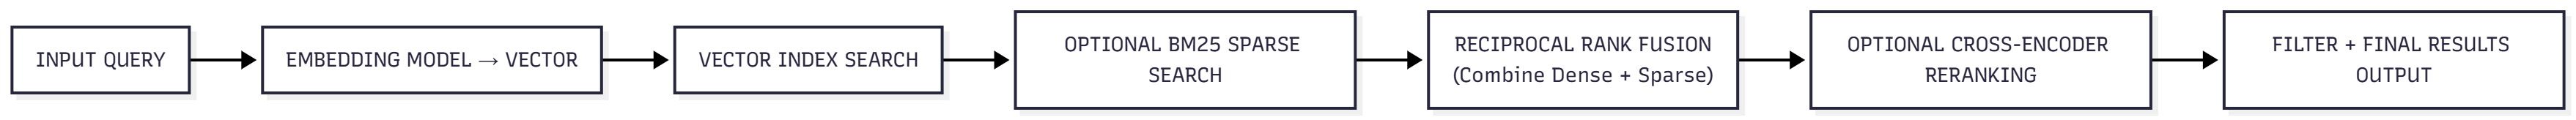


`pseudocode of AdvancedVectorDB`

```text

CLASS AdvancedVectorDB:

    FUNCTION __init__(embedding_model_name = "all-mpnet-base-v2",
                      index_type = "hnsw",
                      dimension = 768):

        LOAD embedding_model FROM SentenceTransformer(embedding_model_name)
        SET dimension = dimension
        SET index_type = index_type

        IF index_type == "hnsw":
            index ← HNSW index with M = 32
        ELSE IF index_type == "ivf":
            quantizer ← FlatL2 quantizer
            index ← IVF-Flat index using quantizer and 100 clusters
        ELSE IF index_type == "lsh":
            index ← LSH index with 2 × dimension bits
        ELSE:
            index ← FlatL2 index

        INITIALIZE:
            documents ← empty list
            metadata ← empty list
            embedding_cache ← empty dictionary
            query_stats ← { total_queries = 0, avg_query_time = 0, cache_hits = 0 }


    FUNCTION add_documents(documents, metadata = None, batch_size = 32):

        IF metadata is None:
            metadata ← [{}] * LENGTH(documents)

        FOR each batch (batch_docs, batch_meta) in documents partitioned by batch_size:
            embeddings ← embedding_model.encode(batch_docs)
            embeddings_np ← convert_to_numpy(embeddings)

            IF index_type == "ivf" AND index not trained:
                index.train(embeddings_np)

            index.add(embeddings_np)

            APPEND batch_docs to documents
            APPEND batch_meta to metadata


    FUNCTION search(query, k = 10, filters = None, rerank = False):

        query_stats.total_queries += 1

        cache_key ← (query, k, filters)
        IF cache_key in embedding_cache:
            query_embedding ← embedding_cache[cache_key]
            query_stats.cache_hits += 1
        ELSE:
            query_embedding ← embedding_model.encode([query])
            embedding_cache[cache_key] ← query_embedding

        (distances, indices) ← index.search(query_embedding, k × 2)

        results ← empty list

        FOR each (idx, distance) in (indices, distances):
            IF idx < 0: CONTINUE
            doc_meta ← metadata[idx]
            IF filters exist AND NOT passes_filters(doc_meta, filters): CONTINUE

            similarity ← 1 / (1 + distance)
            APPEND { document = documents[idx],
                     metadata = doc_meta,
                     score = similarity,
                     index = idx } TO results

            IF LENGTH(results) ≥ k: BREAK

        IF rerank == True:
            results ← rerank_results(query, results)

        RETURN results


    FUNCTION hybrid_search(query, k = 10, alpha = 0.5):

        dense_results ← search(query, k × 2)
        sparse_results ← bm25_search(query, k × 2)
        combined ← reciprocal_rank_fusion([dense_results, sparse_results],
                                          weights = [alpha, 1 - alpha])
        RETURN first k results from combined


    FUNCTION bm25_search(query, k = 10):

        IF bm25_index not exists:
            tokenized_docs ← tokenize each document
            bm25_index ← BM25Okapi(tokenized_docs)

        tokenized_query ← tokenize(query)
        scores ← bm25_index.get_scores(tokenized_query)
        top_indices ← top k indices of scores (descending)

        results ← []
        FOR each idx in top_indices:
            APPEND { document = documents[idx],
                     metadata = metadata[idx],
                     score = scores[idx],
                     index = idx } TO results

        RETURN results


    FUNCTION reciprocal_rank_fusion(result_lists, weights = None, k = 60):

        IF weights is None:
            weights ← [1.0] × LENGTH(result_lists)

        rrf_scores ← empty dictionary

        FOR each (weight, results) in ZIP(weights, result_lists):
            FOR rank, result IN ENUMERATE(results, starting at 1):
                doc_id ← result.index
                rrf_scores[doc_id] += weight × (1 / (k + rank))

        sorted_docs ← sort rrf_scores by descending value

        final_results ← []
        FOR each (doc_id, rrf_score) in sorted_docs:
            APPEND { document = documents[doc_id],
                     metadata = metadata[doc_id],
                     score = rrf_score,
                     index = doc_id } TO final_results

        RETURN final_results


    FUNCTION rerank_results(query, results):

        IF cross_encoder not initialized:
            cross_encoder ← load model "cross-encoder/ms-marco-MiniLM-L-6-v2"

        pairs ← [[query, result.document] for each result in results]
        scores ← cross_encoder.predict(pairs)

        FOR each (result, score) IN ZIP(results, scores):
            result.rerank_score ← score

        SORT results by descending rerank_score
        RETURN results


    FUNCTION passes_filters(metadata, filters):

        FOR each (key, value) in filters:
            IF key not in metadata: RETURN False

            IF value is list AND metadata[key] not in value:
                RETURN False
            ELSE IF value is dict:
                IF "min" in value AND metadata[key] < value["min"]: RETURN False
                IF "max" in value AND metadata[key] > value["max"]: RETURN False
            ELSE IF metadata[key] ≠ value:
                RETURN False

        RETURN True


    FUNCTION get_statistics():

        RETURN {
            total_documents = LENGTH(documents),
            index_size = index.ntotal,
            dimension = dimension,
            index_type = index_type,
            query_stats = query_stats,
            cache_size = LENGTH(embedding_cache)
        }


END CLASS
```

---

<h3 style="font-size:20px; font-weight:bold;">3.2.2 Example: Agent Orchestration with LangChain</h3>

In this section, we will examine the pseudocode of Agent Orchestration with LangChain. This orchestrator builds a ReAct-style agent (Reason–Act–Observe) in LangChain that can choose among several tools (vector search, hybrid search, analyze/compare/summarize/verify), keep a running memory of the dialog, and follow a structured prompt format that forces the LLM to think, act, and then finish with a grounded answer. This turns a pure LLM into a tool-using, retrieval-aware problem solver.

`pseudocode of ReAct agent with LangChain`

---

```text

GOAL:
  Build a ReAct-style agent that:
    - Uses TOOLS (vector search, hybrid search, analyze, compare, summarize, extract facts, verify)
    - Keeps MEMORY of the conversation (summarized)
    - Follows a structured Thought -> Action -> Observation loop until Final Answer

------------------------------------------------------------
CLASS CustomPromptTemplate:
  INPUTS: template_string, tools_list
  METHOD format(input, intermediate_steps):
    thoughts_text <- ""
    FOR each (action, observation) IN intermediate_steps:
      thoughts_text += "Thought: I need to {action.tool} with input: {action.tool_input}\n"
      thoughts_text += "Observation: {observation}\n"
    tool_catalog    <- JOIN("\n", "{tool.name}: {tool.description}" FOR tool IN tools_list)
    tool_name_list  <- JOIN(", ", tool.name FOR tool IN tools_list)
    RETURN template_string FILLED WITH:
      {input, agent_scratchpad = thoughts_text, tools = tool_catalog, tool_names = tool_name_list}

------------------------------------------------------------
CLASS CustomOutputParser:
  METHOD parse(llm_output):
    IF "Final Answer:" IN llm_output:
      answer <- TEXT AFTER "Final Answer:"
      RETURN AgentFinish(output = TRIM(answer), log = llm_output)
    ELSE:
      // Expect format:
      // Action: <TOOL_NAME>
      // Action Input: <ARGUMENTS>
      action_name  <- REGEX CAPTURE after "Action:"
      action_input <- REGEX CAPTURE after "Action Input:"
      RETURN AgentAction(tool = TRIM(action_name), tool_input = CLEAN_QUOTES(TRIM(action_input)), log = llm_output)

------------------------------------------------------------
CLASS AgenticRAGOrchestrator:
  FIELDS:
    llm
    vector_db
    tools
    agent_executor

  CONSTRUCTOR(llm, vector_db, tools = None):
    self.llm <- llm
    self.vector_db <- vector_db
    self.tools <- tools IF provided ELSE create_default_tools()
    self.agent_executor <- setup_agent()

  METHOD create_default_tools():
    RETURN [
      Tool "VectorSearch":     func = vector_search,     desc = "Semantic similarity search (dense). Input: query"
      Tool "HybridSearch":     func = hybrid_search,     desc = "Dense + BM25 fusion. Input: query"
      Tool "AnalyzeDocument":  func = analyze_document,  desc = "Input: 'doc_index|analysis_query'"
      Tool "CompareDocuments": func = compare_documents, desc = "Input: 'idx1,idx2|criteria'"
      Tool "SummarizeResults": func = summarize_results, desc = "Input: number_of_results"
      Tool "ExtractFacts":     func = extract_facts,     desc = "Input: fact_type"
      Tool "VerifyClaim":      func = verify_claim,      desc = "Input: claim_text"
    ]

  #TOOL IMPLEMENTATIONS
  METHOD vector_search(query):
    results <- vector_db.search(query, k = 5)
    IF results is empty: RETURN "No relevant documents found."
    RETURN formatted top results with scores + metadata

  METHOD hybrid_search(query):
    results <- vector_db.hybrid_search(query, k = 5)
    IF results is empty: RETURN "No relevant documents found in hybrid search."
    RETURN formatted top results with scores

  METHOD analyze_document("doc_index|analysis_query"):
    (idx, q) <- PARSE input
    IF idx out of range: RETURN "Invalid document index"
    doc <- vector_db.documents[idx]
    prompt <- "Analyze doc for: {q}\nDocument: {doc}\nAnalysis:"
    analysis <- llm.invoke(prompt)
    RETURN "Analysis of document {idx}: {analysis}"

  METHOD compare_documents("idx1,idx2|criteria"):
    (indices, criteria) <- PARSE input
    docs <- COLLECT vector_db.documents[i] FOR each valid i in indices
    IF docs empty: RETURN "No valid documents to compare."
    prompt <- "Compare docs by {criteria}\n{docs_as_block}\nComparison:"
    comparison <- llm.invoke(prompt)
    RETURN "Document comparison: {comparison}"

  METHOD summarize_results(num_results_string):
    n <- PARSE INT(num_results_string) OR ERROR
    RETURN "Summary of last {n} search results: [depends on cached tracking]"

  METHOD extract_facts(fact_type):
    results <- vector_db.search(fact_type, k = 3)
    IF empty: RETURN "No documents found containing {fact_type}."
    facts <- []
    FOR r IN results:
      prompt <- "Extract facts about {fact_type} from:\n{r.document}\nList the facts:"
      facts += llm.invoke(prompt)
    RETURN "Extracted facts about {fact_type}:\n" + JOIN("\n", facts)

  METHOD verify_claim(claim):
    results <- vector_db.search(claim, k = 5)
    IF empty: RETURN "No evidence found to verify the claim: {claim}"
    evidence_block <- BULLET_LIST(top snippets from results)
    prompt <- "Verify claim: {claim}\nEvidence:\n{evidence_block}\nReturn Supported/Contradicted/Insufficient + rationale:"
    verification <- llm.invoke(prompt)
    RETURN "Claim verification: {verification}"

  # AGENT WIRING (ReAct loop)
  METHOD setup_agent():
    base_template <- """
      You are an advanced agentic RAG system. Use tools to search/analyze.

      Available tools:
      {tools}

      Use this strict format:
      Question: <user question>
      Thought: <what you will do next>
      Action: <one of [{tool_names}]>
      Action Input: <parameters for the action>
      Observation: <tool result>
      ... (repeat Thought/Action/Action Input/Observation as needed)
      Thought: I now know the final answer
      Final Answer: <your final answer>

      Question: {input}
      {agent_scratchpad}
    """
    prompt <- CustomPromptTemplate(template = base_template, tools = self.tools)
    memory <- ConversationSummaryBufferMemory(llm = self.llm, max_token_limit = 2000)
    llm_chain <- LLMChain(llm = self.llm, prompt = prompt)
    agent <- LLMSingleActionAgent(
              llm_chain = llm_chain,
              output_parser = CustomOutputParser(),
              stop = ["\nObservation:"],
              allowed_tools = [tool.name FOR tool IN self.tools]
            )
    executor <- AgentExecutor.from_agent_and_tools(
                  agent = agent,
                  tools = self.tools,
                  verbose = True,
                  memory = memory,
                  max_iterations = 10
                )
    RETURN executor

  METHOD run(query):
    RETURN agent_executor.run(query)

------------------------------------------------------------

FUNCTION demonstrate_langchain_orchestration():
  llm <- OpenAI(temperature = 0.7)            // or any compatible LLM
  vector_db <- AdvancedVectorDB()             // your dense/hybrid retriever
  vector_db.add_documents(documents, metadata)

  orchestrator <- AgenticRAGOrchestrator(llm, vector_db)

  FOR each query IN [
      "What is the relationship between ML and DL?",
      "How do transformers relate to RAG systems?",
      "Compare difficulty levels of topics in DB."
    ]:
    response <- orchestrator.run(query)
    PRINT response

```
---

<h1 id="references" style="font-size:23px; font-weight:bold">References</h1>

**Foundational Papers**

1. Yao, S., Zhao, J., Yu, D., Du, N., Shafran, I., Narasimhan, K., & Cao, Y. (2023). "ReAct: Synergizing Reasoning and Acting in Language Models." ICLR 2023. arXiv:2210.03629

2. Shinn, N., Cassano, F., Labash, B., Gopinath, A., Narasimhan, K., & Yao, S. (2023). "Reflexion: Language Agents with Verbal Reinforcement Learning." NeurIPS 2023. arXiv:2303.11366

3. Asai, A., Wu, Z., Wang, Y., Sil, A., & Hajishirzi, H. (2024). "Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection." ICLR 2024. arXiv:2310.11511

4. Jiang, Z., Xu, F. F., Gao, L., Sun, Z., Liu, Q., Dwivedi-Yu, J., & Neubig, G. (2023). "Active Retrieval Augmented Generation." EMNLP 2023. arXiv:2305.06983


**Multi-Hop Reasoning and Retrieval**

5. Xiong, W., Li, X. L., Iyer, S., Du, J., Lewis, P., Wang, W. Y., & Yih, W. T. (2021). "Answering Complex Open-Domain Questions with Multi-Hop Dense Retrieval." ICLR 2021. arXiv:2009.12756

6. Trivedi, H., Balasubramanian, N., Khot, T., & Sabharwal, A. (2022). "Interleaving Retrieval with Chain-of-Thought Reasoning for Knowledge-Intensive Multi-Step Questions." ACL 2023. arXiv:2212.10509

7. Yang, Z., Qi, P., Zhang, S., Bengio, Y., Cohen, W. W., Salakhutdinov, R., & Manning, C. D. (2018). "HotpotQA: A Dataset for Diverse, Explainable Multi-hop Question Answering." EMNLP 2018. arXiv:1809.09600

8. Khattab, O., Santhanam, K., Li, X. L., Hall, D., Liang, P., Potts, C., & Zaharia, M. (2021). "Baleen: Robust Multi-Hop Reasoning at Scale via Condensed Retrieval." NeurIPS 2021. arXiv:2101.00436


**Chain-of-Thought and Reasoning**

9. Wei, J., Wang, X., Schuurmans, D., Bosma, M., Ichter, B., Xia, F., & Zhou, D. (2022). "Chain-of-Thought Prompting Elicits Reasoning in Large Language Models." NeurIPS 2022. arXiv:2201.11903

10. Wang, X., Wei, J., Schuurmans, D., Le, Q., Chi, E., Narang, S., & Zhou, D. (2023). "Self-Consistency Improves Chain of Thought Reasoning in Language Models." ICLR 2023. arXiv:2203.11171

11. Yao, S., Yu, D., Zhao, J., Shafran, I., Griffiths, T. L., Cao, Y., & Narasimhan, K. (2023). "Tree of Thoughts: Deliberate Problem Solving with Large Language Models." NeurIPS 2023. arXiv:2305.10601


**Query Decomposition and Planning**

12. Khot, T., Trivedi, H., Finlayson, M., Fu, Y., Richardson, K., Clark, P., & Sabharwal, A. (2023). "Decomposed Prompting: A Modular Approach for Solving Complex Tasks." ICLR 2023. arXiv:2210.02406

13. Zhou, D., Schärli, N., Hou, L., Wei, J., Scales, N., Wang, X., & Chi, E. (2023). "Least-to-Most Prompting Enables Complex Reasoning in Large Language Models." ICLR 2023. arXiv:2205.10625

14. Wang, L., Xu, W., Lan, Y., Hu, Z., Lan, Y., Lee, R. K. W., & Lim, E. P. (2023). "Plan-and-Solve Prompting: Improving Zero-Shot Chain-of-Thought Reasoning by Large Language Models." ACL 2023. arXiv:2305.04091

15. Pereira, F., Hsu, Y., Talukdar, P., & Gupta, P. (2023). "Decomposing Complex Queries for Tip-of-the-tongue Retrieval." ACL 2023.
Min, S., Zhong, V., Zettlemoyer, L., & Hajishirzi, H. (2019). "Multi-hop Reading Comprehension through Question Decomposition and Rescoring." ACL 2019. arXiv:1906.02916


**Retrieval Methods and Techniques**

16. Cormack, G. V., Clarke, C. L., & Buettcher, S. (2009). "Reciprocal rank fusion outperforms condorcet and individual rank learning methods." SIGIR 2009. Pages 758-759.

17. Robertson, S., & Zaragoza, H. (2009). "The Probabilistic Relevance Framework: BM25 and Beyond." Foundations and Trends in Information Retrieval, 3(4), 333-389.

18. Karpukhin, V., Oğuz, B., Min, S., Lewis, P., Wu, L., Edunov, S., & Yih, W. T. (2020). "Dense Passage Retrieval for Open-Domain Question Answering." EMNLP 2020. arXiv:2004.04906

19. Ma, X., Sun, K., Pradeep, R., Li, M., & Lin, J. (2022). "A Replication Study of Dense Passage Retriever." arXiv:2104.05740

20. Nogueira, R., & Cho, K. (2019). "Passage Re-ranking with BERT." arXiv:1901.04085


**Vector Databases and Indexing**

21. Johnson, J., Douze, M., & Jégou, H. (2019). "Billion-scale similarity search with GPUs." IEEE Transactions on Big Data, 7(3), 535-547. arXiv:1702.08734

22. Malkov, Y. A., & Yashunin, D. A. (2020). "Efficient and robust approximate nearest neighbor search using hierarchical navigable small world graphs." IEEE TPAMI, 42(4), 824-836. arXiv:1603.09320

23. Andoni, A., & Indyk, P. (2008). "Near-optimal hashing algorithms for approximate nearest neighbor in high dimensions." Communications of the ACM, 51(1), 117-122.


**Attribution and Hallucination Detection**

24. Menick, J., Trebacz, M., Mikulik, V., Aslanides, J., Song, F., Chadwick, M., ... & McAleese, N. (2022). "Teaching language models to support answers with verified quotes." arXiv:2203.11147

25. Gao, L., Dai, Z., Pasupat, P., Chen, A., Chaganty, A. T., Fan, Y., & Guu, K. (2023). "RARR: Researching and Revising What Language Models Say, Using Language Models." ACL 2023. arXiv:2210.08726

26. Manakul, P., Liusie, A., & Gales, M. J. (2023). "SelfCheckGPT: Zero-Resource Black-Box Hallucination Detection for Generative Large Language Models." EMNLP 2023. arXiv:2303.08896

27. Kadavath, S., Conerly, T., Askell, A., Henighan, T., Drain, D., Perez, E., & Kaplan, J. (2022). "Language Models (Mostly) Know What They Know." arXiv:2207.05221


**Tool Use and Function Calling**

28. Schick, T., Dwivedi-Yu, J., Dessì, R., Raileanu, R., Lomeli, M., Zettlemoyer, L., & Scialom, T. (2023). "Toolformer: Language Models Can Teach Themselves to Use Tools." NeurIPS 2023. arXiv:2302.04761

29. Nakano, R., Hilton, J., Balaji, S., Wu, J., Ouyang, L., Kim, C., & Schulman, J. (2021). "WebGPT: Browser-assisted question-answering with human feedback." arXiv:2112.09332

30. Gao, L., Madaan, A., Zhou, S., Alon, U., Liu, P., Yang, Y., & Neubig, G. (2023). "PAL: Program-aided Language Models." ICML 2023. arXiv:2211.10435


**Memory Systems in AI Agents**

31. Packer, C., Wooders, S., Lin, K., Fang, V., Patil, S., Stoica, I., & Gonzalez, J. E. (2023). "MemGPT: Towards LLMs as Operating Systems." arXiv:2310.08560

32. Park, J. S., O'Brien, J. C., Cai, C. J., Morris, M. R., Liang, P., & Bernstein, M. S. (2023). "Generative Agents: Interactive Simulacra of Human Behavior." UIST 2023. arXiv:2304.03442

33. Weston, J., Chopra, S., & Bordes, A. (2015). "Memory Networks." ICLR 2015. arXiv:1410.3916

34. Graves, A., Wayne, G., & Danihelka, I. (2014). "Neural Turing Machines." arXiv:1410.5401


**Framework Papers and Implementations**

35. Chase, H. (2023). "LangChain: Building applications with LLMs through composability." GitHub repository. https://github.com/langchain-ai/langchain

36. Liu, J. (2023). "LlamaIndex: Data Framework for LLM Applications." GitHub repository. https://github.com/jerryjliu/llama_index

37. Khattab, O., Singhvi, A., Maheshwari, P., Zhang, Z., Santhanam, K., Vardhamanan, S., ... & Zaharia, M. (2023). "DSPy: Compiling Declarative Language Model Calls into Self-Improving Pipelines." arXiv:2310.03714


**Evaluation Metrics and Benchmarks**

38. Es, S., James, J., Espinosa-Anke, L., & Schockaert, S. (2024). "RAGAS: Automated Evaluation of Retrieval Augmented Generation." arXiv:2309.15217

39. Chen, J., Lin, H., Han, X., & Sun, L. (2024). "Benchmarking Large Language Models in Retrieval-Augmented Generation." AAAI 2024. arXiv:2309.01431


**Historical Context and Foundations**

40. Moldovan, D., Harabagiu, S., Pasca, M., Mihalcea, R., Goodrum, R., Gîrju, R., & Rus, V. (2003). "The structure and performance of an open-domain question answering system." ACL 2003.

41. Manning, C. D., Raghavan, P., & Schütze, H. (2008). "Introduction to Information Retrieval." Cambridge University Press.

42. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., & Polosukhin, I. (2017). "Attention is All You Need." NeurIPS 2017. arXiv:1706.03762


**Additional Advanced Topics**

43. Qi, P., Lee, H., Sido, O., & Manning, C. D. (2021). "Retrieve, Rerank, Read, then Iterate: Answering Open-Domain Questions of Arbitrary Complexity from Text." arXiv:2010.12527

44. Borgeaud, S., Mensch, A., Hoffmann, J., Cai, T., Rutherford, E., Millican, K., & Sifre, L. (2022). "Improving language models by retrieving from trillions of tokens." ICML 2022. arXiv:2112.04426

45. Sun, S., Liu, Y., Iter, D., Zhu, C., & Iyyer, M. (2023). "PEARL: Prompting Large Language Models to Plan and Execute Actions Over Long Documents." arXiv:2305.14564

46. Richards, T. (2023). "Auto-GPT: An Autonomous GPT-4 Experiment." GitHub repository. https://github.com/Significant-Gravitas/Auto-GPT


**Industry Reports and Practical Guides**

47. Microsoft (2023). "Guidance: A guidance language for controlling large language models." https://github.com/microsoft/guidance

48. OpenAI (2023). "Function calling and other API updates." OpenAI Blog. https://openai.com/blog/function-calling-and-other-api-updates

49. Bai, Y., Kadavath, S., Kundu, S., Askell, A., Kernion, J., Jones, A., & Kaplan, J. (2022). "Constitutional AI: Harmlessness from AI Feedback." arXiv:2212.08073


**Books and Comprehensive Resources**

50. Büttcher, S., Clarke, C. L., & Cormack, G. V. (2016). "Information Retrieval: Implementing and Evaluating Search Engines." MIT Press.

51. Jurafsky, D., & Martin, J. H. (2023). "Speech and Language Processing (3rd ed. draft)." https://web.stanford.edu/~jurafsky/slp3/

In [1]:
%%html
<style>
    table {margin-left: 0 !important;}
    p {font-family: verdana;}
    li {font-family: verdana;}
    div {font-size: 10pt;}
</style>
<!-- Display markdown tables left oriented in this notebook. -->

***
***